# Single cell transcriptomic analysis of all samples (primary tumors, controls, allografted cells and tumors)

In [40]:
library(ggplot2)
library(ggrepel)
library(plyr)
library(dplyr)
library(Seurat)
library(DescTools)
library(SingleR)
library(viridis)
library(RColorBrewer)

source("../sc_analysis_palettes_and_helpers.r")

dat_name <- "all_timepoints_merged"


## Load and filter data

In [4]:
# Reload cells from primary tumors and controls (all merged and annotated)
load("./data/allmerged_final_named_complete.Robj")

# Store metadata separately
metadata_pts <- all.comb@meta.data
metadata_pts$Barcode_pts <- rownames(metadata_pts)

In [ ]:
# Early grafts

load('/data/remap_DR_NB/multi_bAllos_1/trnscrptm/multi_bAllos_1_clustered.Robj')
ea_b1_dat <- subset(dat, orig.ident == 'multi_bAllos_1_allos')
ea_b1_dat <- subset(x = ea_b1_dat, subset = nFeature_RNA > 200)
rm(dat)

load('/data/remap_DR_NB/multi_bAllos_2/trnscrptm/multi_bAllos_2_allos_clustered.Robj')
ea_b2_dat <- dat
ea_b2_dat <- subset(x = ea_b2_dat, subset = nFeature_RNA > 200)
rm(dat)

load('/data/remap_DR_NB/multi_bAllos_3/trnscrptm/multi_bAllos_3_clustered.Robj')
ea_b3_dat <- subset(dat, orig.ident == 'multi_bAllos_3_allos')
ea_b3_dat <- subset(x = ea_b3_dat, subset = nFeature_RNA > 200)
rm(dat)

load('/data/remap_DR_NB/multi_bAllos_4/trnscrptm/multi_bAllos_4_clustered.Robj')
ea_b4_dat <- subset(dat, orig.ident == 'multi_bAllos_4_allos')
ea_b4_dat <- subset(x = ea_b4_dat, subset = nFeature_RNA > 200)
rm(dat)


In [ ]:
# Late grafts
load('/data/remap_DR_NB/multi_lateAllos_1/trnscrptm/multi_lateAllos_1_named.Robj')
la_1_dat <- subset(x = dat, subset = nFeature_RNA > 200)\
rm(dat)

load('/data/remap_DR_NB/multi_bAllos_2/trnscrptm/multi_bAllos_2_lateAllos_clustered.Robj')
la_2_dat <- subset(x = dat, subset = nFeature_RNA > 200)\
rm(dat)


load('/data/remap_DR_NB/multi_bAllos_4/trnscrptm/multi_bAllos_4_clustered.Robj')
la_3_dat <- subset(dat, orig.ident %in% c('multi_bAllos_4_lateAllos_S1','multi_bAllos_4_lateAllos_S2','multi_bAllos_4_lateAllos_02_S2'))
la_3_dat <- subset(x = la_3_dat, subset = nFeature_RNA > 200)\
rm(dat)


## Merge data

In [ ]:
# Merge all; Set 'merge.data = F', so that existing metadata is not merged
dat <- merge(all.comb, y = c(ea_b1_dat, ea_b2_dat, ea_b3_dat, ea_b4_dat, la_1_dat, la_2_dat, la_3_dat),
                  add.cell.ids = c('pts', 'ea_b1', 'ea_b2', 'ea_b3', 'ea_b4','la_1', 'la_b2', 'la_b4'),
                  project = "allDRNB", merge.data = F)

## Process merged data
### Normalize and scale

In [ ]:
dat <- NormalizeData(dat)

# scale all
all.genes <- rownames(x = dat)
dat <- ScaleData(object = dat, features = all.genes)

# save object
save(dat, file = paste0(dat_name,"_scaled.Robj"))


### Find variable features
and remove potential batch-effect-associated genes from hvg list.

In [ ]:
load(paste0(dat_name,"_scaled.Robj"))

In [ ]:
# Find batch associated genes - i.e. those that are consistently more highly 'expressed' across cell types of a sample compared to all other samples
Idents(dat) <- "orig.ident"

to.regress <- FindAllMarkers(object = dat, only.pos = TRUE, min.pct = 0.8, logfc.threshold = 0.3)
to.regress <- to.regress$gene
to.regress <- unique(to.regress)

# Print out list of genes
write.csv(to.regress, file = paste0("genestoregress_",dat_name,".csv"), quote = F)

In [ ]:
# Find variable genes and remove those that were found to be batch-effect associated
# Further remove cell cycle marker genes and blood / immune cell derived genes that are often contaminating
# Also remove the human transgenes

# load genes to regress
to.regress <- read.delim("genestoregress_all_timepoints_merged.csv",
  sep = ',', stringsAsFactors = F, row.names = 1
  )
to.regress <- to.regress$x

# Load genes associated with the cell cycle that should also be excluded for clustering
to.regress.cellcycle <- read.csv("zfish_prolif_markers.csv")
to.regress.cellcycle <- as.character(to.regress.cellcycle$x)

regress_blood <- c("hbba1","hbba1.1","hbae1","hbbe2","hbbe1.1","lyz","lect2l","mmp9","cd74a","cd74b","c1qb","c1qc")

dat <- FindVariableFeatures(object = dat,selection.method = 'vst', nfeatures = 2000)
var_feats <- VariableFeatures(object = dat)
var_feats <- var_feats[!var_feats %in% c("mCherry", "EGFP","MYCN", "LMO1", "BIRC5","dTomato")]
var_feats <- var_feats[!var_feats %in% to.regress]
var_feats <- var_feats[!var_feats %in% to.regress.cellcycle]
var_feats <- var_feats[!var_feats %in% regress_blood]


### Run PCA

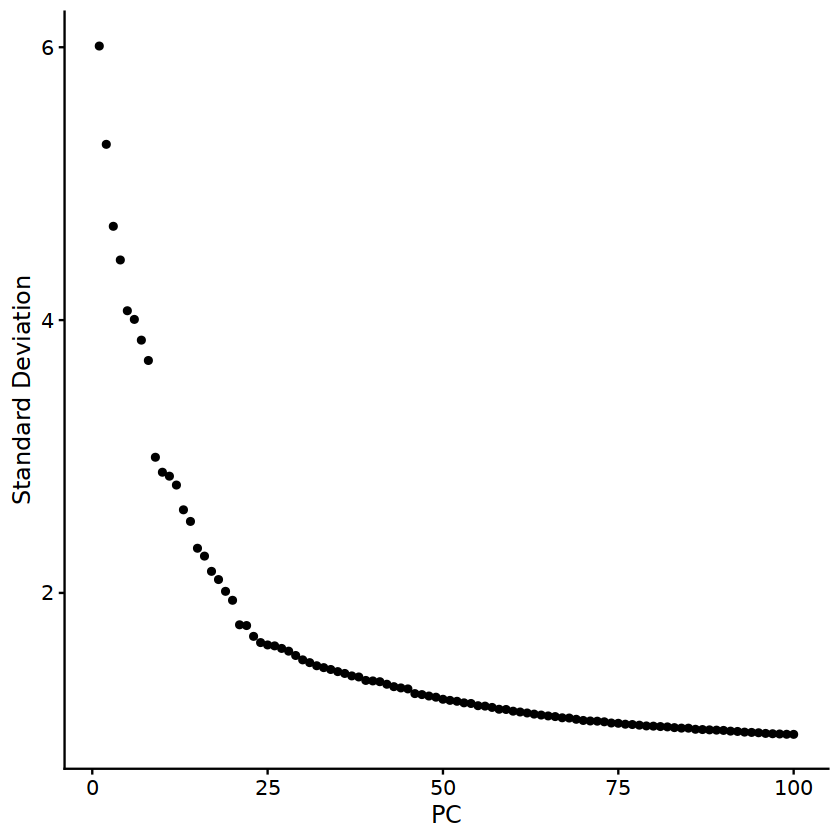

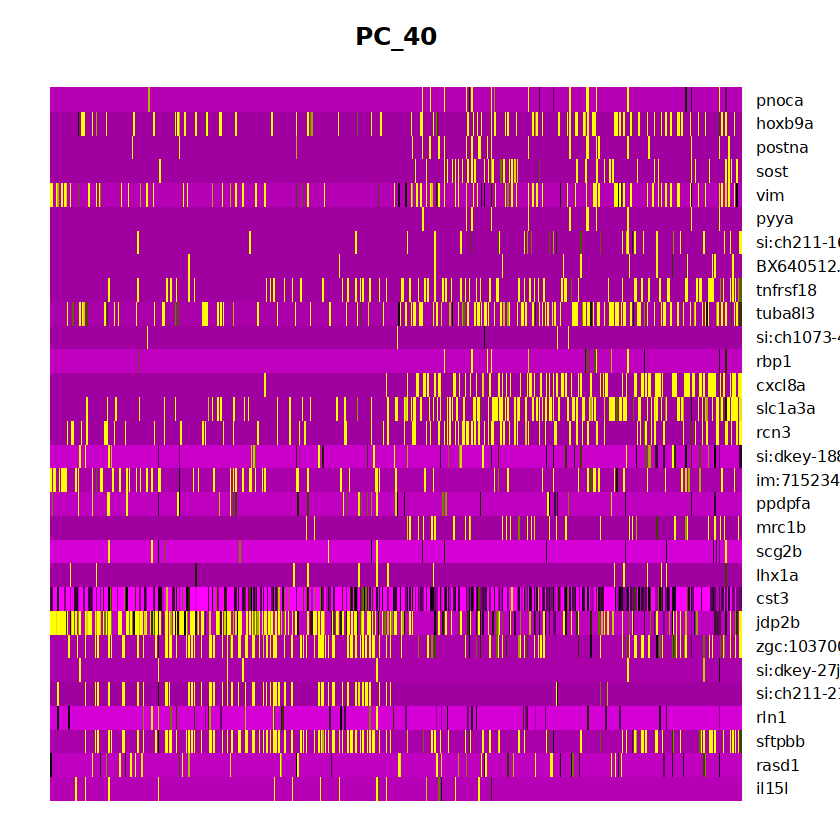

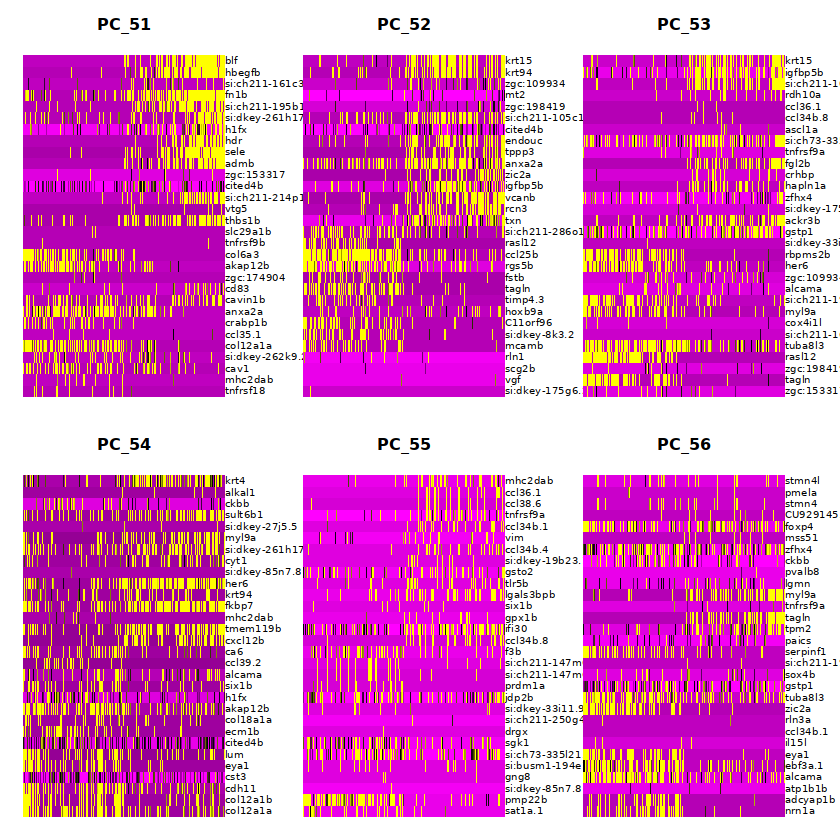

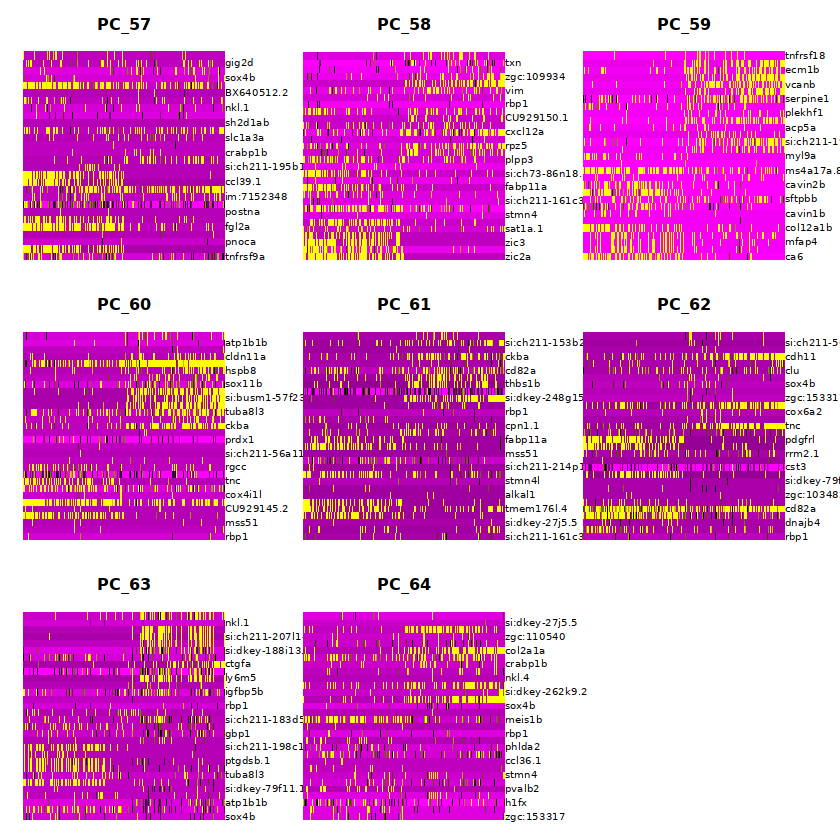

In [4]:
# Run PCA 
dat <- RunPCA(dat, features = var_feats, npcs= 100)

# Plots for PC-number selection
ElbowPlot(object = dat, ndims = 100)
DimHeatmap(object = dat, dims = 40:40, cells = 500, balanced = TRUE)
DimHeatmap(object = dat, dims = 51:56, cells = 500, balanced = TRUE)
DimHeatmap(object = dat, dims = 57:64, cells = 500, balanced = TRUE)


In [6]:
# Set appropriate number of dimensions
ndims <- 60


### Lovain clustering and UMAP

In [ ]:
# Cluster - set parameter k to fit the number of cells in the data
k <- round(max(20,sqrt(ncol(dat)))/4)
if(k %% 2 == 0) {k <- k+1}
if(k > 41) {k <- 41}

dat <- FindNeighbors(object = dat, dims = 1:ndims, k.param = k)
dat <- FindClusters(object = dat, resolution = 1.4)

dat <- RunUMAP(dat, reduction = "pca", dims = 1:ndims)

In [ ]:
save(dat, file = paste0(dat_name,"_clustered.Robj"))

### Cell type annotation

Cell type annotation is based on results from multiple approaches of assigning clusters to cell types.  
1. Plot known cell type marker expression per cluster and assess cluster marker genes to manually annotate clusters.
2. Check sample type and primary tumor cell type contributions to clusters to see whether primary tumor cell types already assigned to a majority of cells in the cluster can be retained. This is also useful for identifying allograft-cell-exclusive clusters, which may e.g. be derived from larval host cells.
3. Use SingleR to assign cell types to clusters based on cell type markers detected in the primary tumor and control sample data.  
**-> Merge information from all approaches to determine final cell types*.*

#### Plot cell type marker gene expression across clusters
Below, I load a combined table of zebrafish cell type marker genes from Tang et al. 2017 (DOI 10.1084/jem.20170976) and Hu et al. 2022 (DOI 10.1038/s41588-022-01129-5). These are derived from scRNA-seq analyses of the zebrafish head kidney (including haematopoietic cells) and the zebrafish heart, respectively. Additionally, a neuroblastoma transgene and marker signature and the ADRN and MES signatures from Van Groningen et al. 2017 (DOI 10.1038/ng.3899) are included.  
Additionally, in the cell below, we also use markers from zebrafish larval cell types from Spanjaard, Hu et al. (DOI 10.1038/nbt.4124), as the early allograft datasets are also expected to contain larval host cells.
  
**Rationale**  
- Calculate expression scores for each signature in all of the clusters using Seurat's AddModuleScore function.
- If a cluster represents a cell type represented in the cell type marker list or a related cell type, it will show an increased expression score for that signature.
- This is used for initial broad cell type annotation.

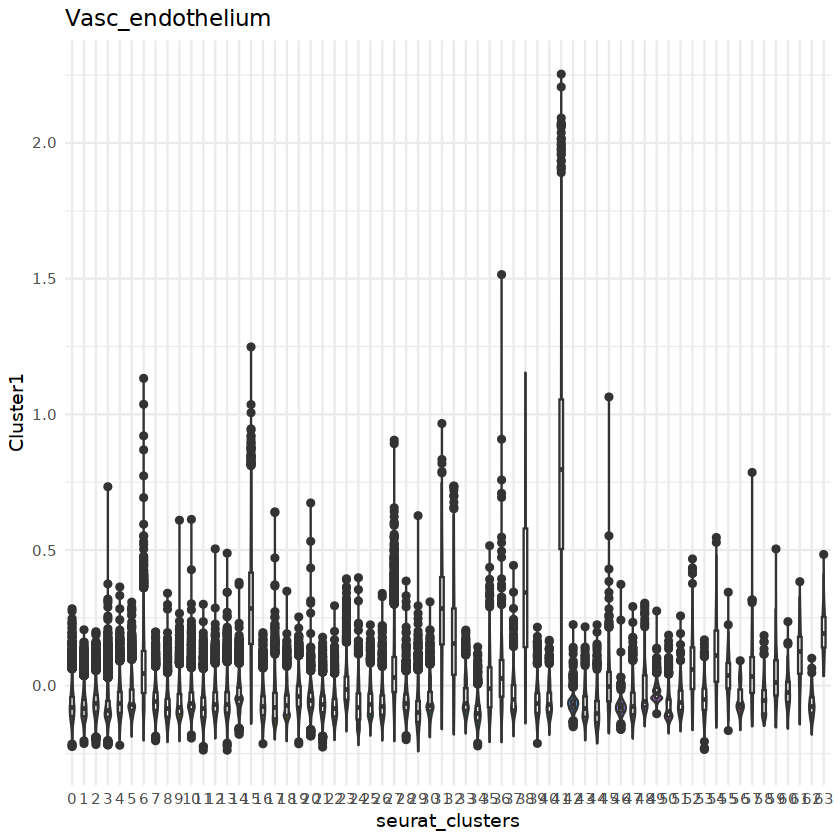

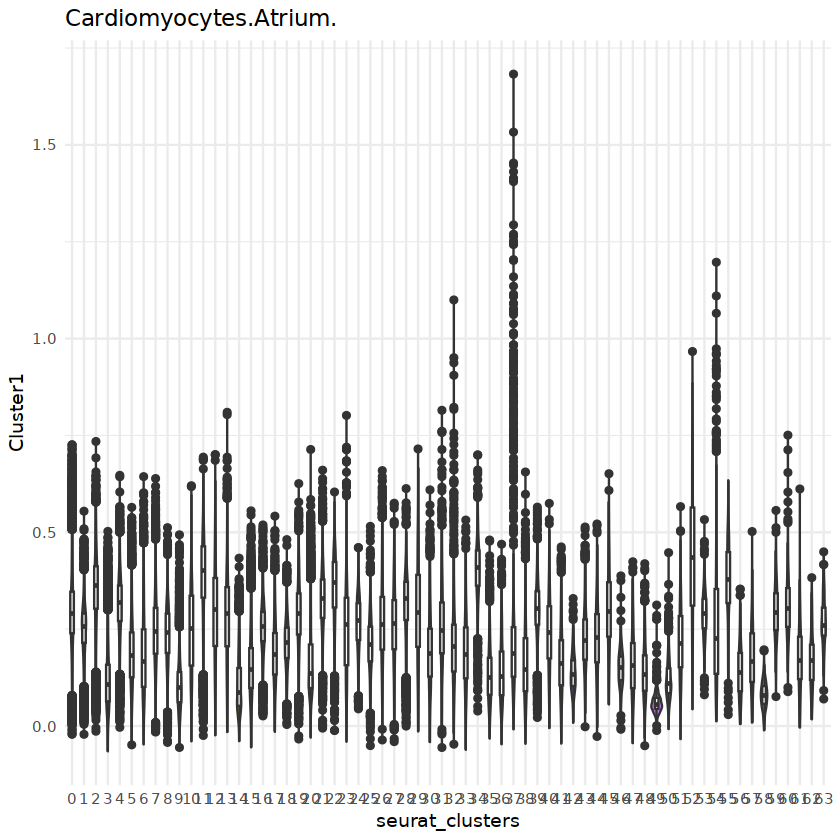

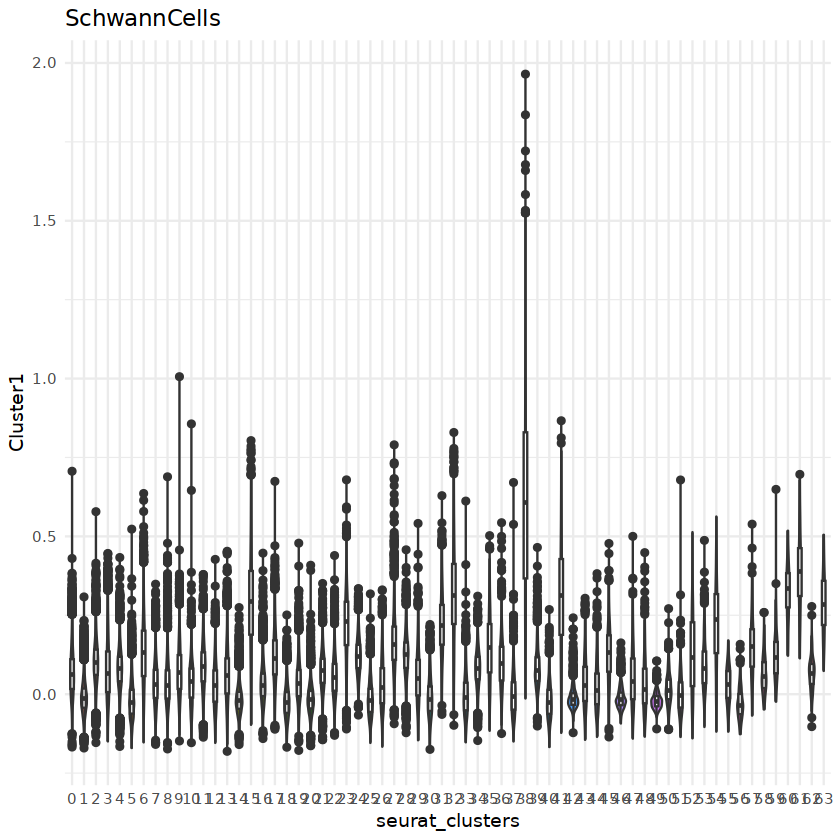

In [20]:
clusterMarkers_all <- read.delim("./celltype_assign_files/celltype_markers_tang_hu_clean.csv", stringsAsFactors = F, sep = ",")

# Select three random signatures for in-line plotting
set.seed(265)
plot_sig_numbs <- sample(1:ncol(clusterMarkers_all), 3)

# Get mean expression of genes of interest per cell and plot mean expression of signature genes
for(i in 1:ncol(clusterMarkers_all)){

    # Extract individual signature.
    # Make sure at least 4 signature genes are present in the data. If not, move on to next signature.
    gene.set <- clusterMarkers_all[,i][is.na(clusterMarkers_all[,i]) == F]
    gene.set <- gene.set[gene.set %in% rownames(GetAssayData(object = dat, slot = "scale.data"))]
    if(length(gene.set) <= 3) next

    avexp_test <- AddModuleScore(
      dat,
      features = list(gene.set),
      enrich.name = "geneset"
    )
    avexp_test <- as.data.frame(avexp_test@meta.data)

    png(paste0("./data_allTPs/pics/VlnPlot_Markers_ModuleScore_",dat_name,"_",colnames(clusterMarkers_all)[i], ".png"), width = 18, height = 5, units = 'in', res = 300)
        print(ggplot(avexp_test, aes(x = seurat_clusters, y = Cluster1, fill = seurat_clusters)) +
                      geom_violin(alpha = 1) +
                      geom_boxplot(width=0.1, fill = "white") +
                      theme_minimal()+
                      theme(legend.position = "none") 
        )
    dev.off()
    
    if(i %in% plot_sig_numbs){
        print(ggplot(avexp_test, aes(x = seurat_clusters, y = Cluster1, fill = seurat_clusters)) +
                      geom_violin(alpha = 1) +
                      geom_boxplot(width=0.3, fill = "white") +
                      ggtitle(paste0(colnames(clusterMarkers_all)[i])) +
                      theme_minimal() +
                      theme(legend.position = "none") 
        )
    }
}

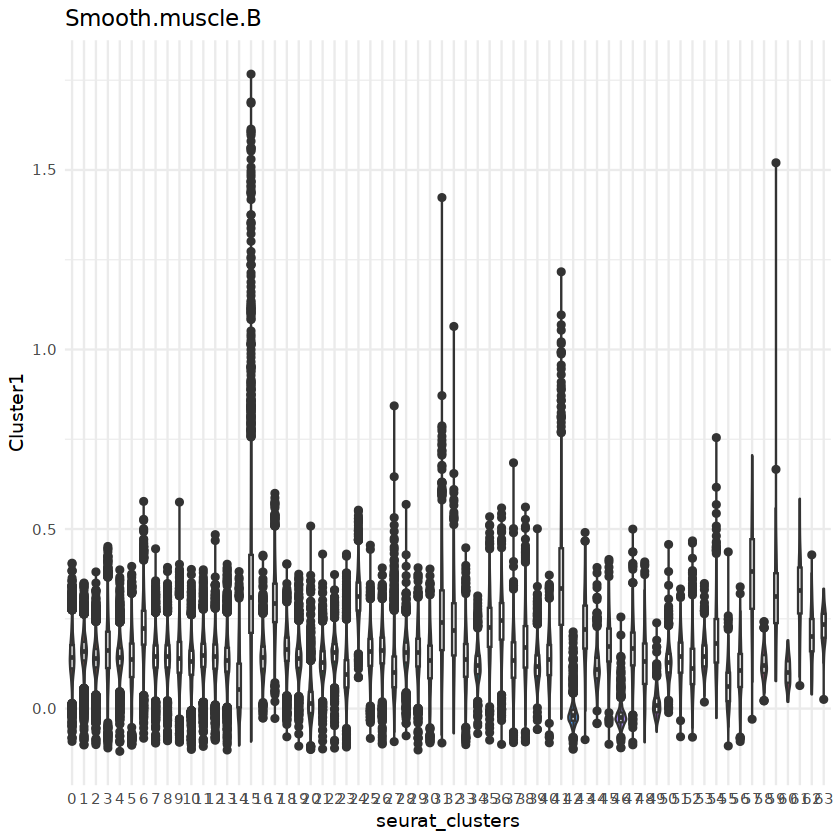

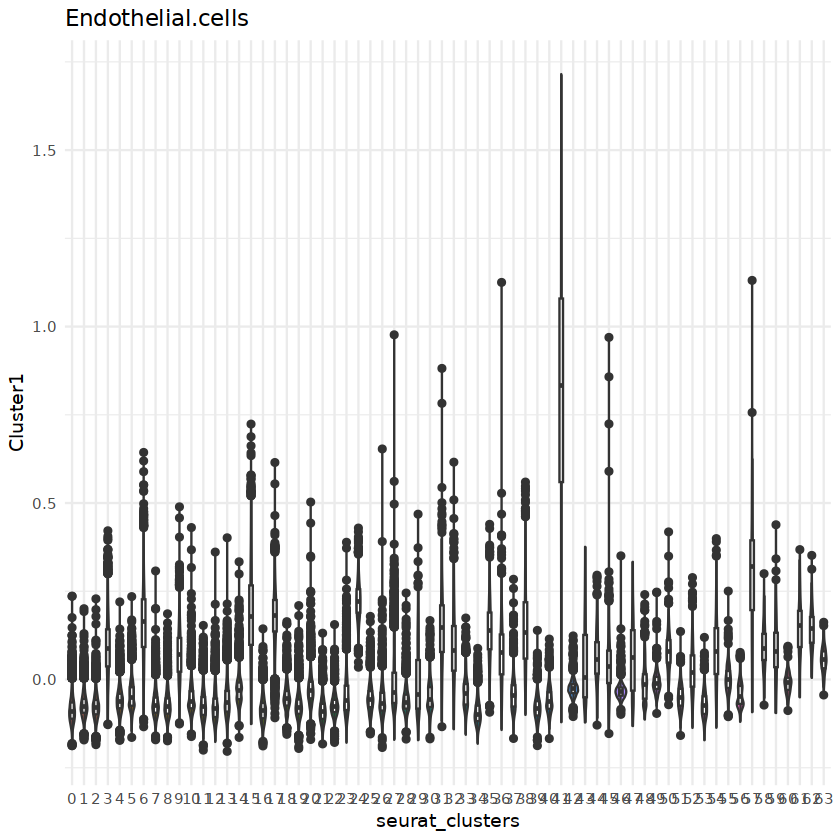

In [21]:

# Read in cluster annotations from Bo's and Bastiaan's paper for larval cell types
  
clusterMarkers_all <- read.delim("./celltype_assign_files_allTPs/Larvae.celltypes.final.csv", stringsAsFactors = F, sep = ";",row.names = 1)
clusterMarkers_all <- clusterMarkers_all[-c(1,2),]

# Select two random signatures for in-line plotting
set.seed(265)
plot_sig_numbs <- sample(1:ncol(clusterMarkers_all), 2)

# Get mean expression of genes of interest per cell and plot mean expression of signature genes
for(i in 1:ncol(clusterMarkers_all)){
 
    # Extract individual signature.
    # Make sure at least 4 signature genes are present in the data. If not, move on to next signature.
    gene.set <- clusterMarkers_all[,i][is.na(clusterMarkers_all[,i]) == F]
    gene.set <- gene.set[gene.set %in% rownames(GetAssayData(object = dat, slot = "scale.data"))]
    if(length(gene.set) <= 3) next

    avexp_test <- AddModuleScore(
      dat,
      features = list(gene.set),
      enrich.name = "geneset"
    )
    avexp_test <- as.data.frame(avexp_test@meta.data)

    png(paste0("./data_allTPs/pics/VlnPlot_Markers_ModuleScore_",dat_name,"_",colnames(clusterMarkers_all)[i], ".png"), width = 18, height = 5, units = 'in', res = 300)
        print(ggplot(avexp_test, aes(x = seurat_clusters, y = Cluster1, fill = seurat_clusters)) +
                      geom_violin(alpha = 1) +
                      geom_boxplot(width=0.1, fill = "white") +
                      theme_minimal()+
                      theme(legend.position = "none") 
        )
    dev.off()
    
    if(i %in% plot_sig_numbs){
        print(ggplot(avexp_test, aes(x = seurat_clusters, y = Cluster1, fill = seurat_clusters)) +
                      geom_violin(alpha = 1) +
                      geom_boxplot(width=0.3, fill = "white") +
                      ggtitle(paste0(colnames(clusterMarkers_all)[i])) +
                      theme_minimal() +
                      theme(legend.position = "none") 
        )
    }
}

#### Find cluster marker genes

In [ ]:
## Reload
dat_name <- 'all_timepoints_merged'
load(paste0(dat_name,"_clustered.Robj"))

In [ ]:
Idents(dat)<- "seurat_clusters"

# get markers:
allcluster_markers <- FindAllMarkers(object = dat, only.pos = TRUE, min.pct = 0.3, logfc.threshold = 0.5)

# save
write.csv(allcluster_markers, file = paste0("clusterMarkersAll_",dat_name,"_withoutbatch_seurclusts_minpct30_logfct_50.csv"))


##### Cell type assignments based on manual cluster annotation

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



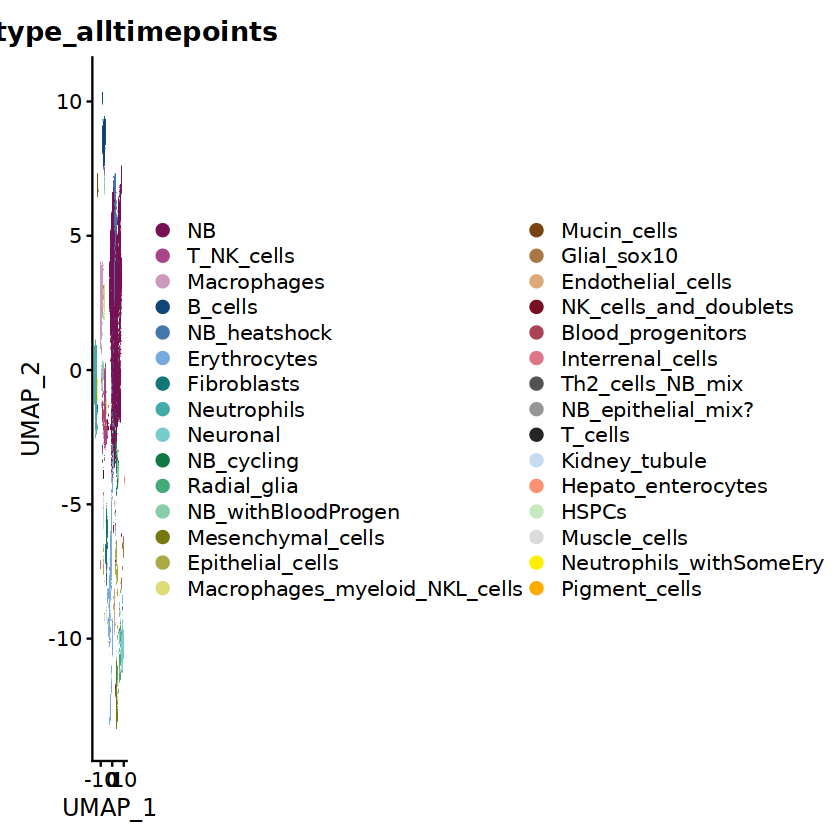

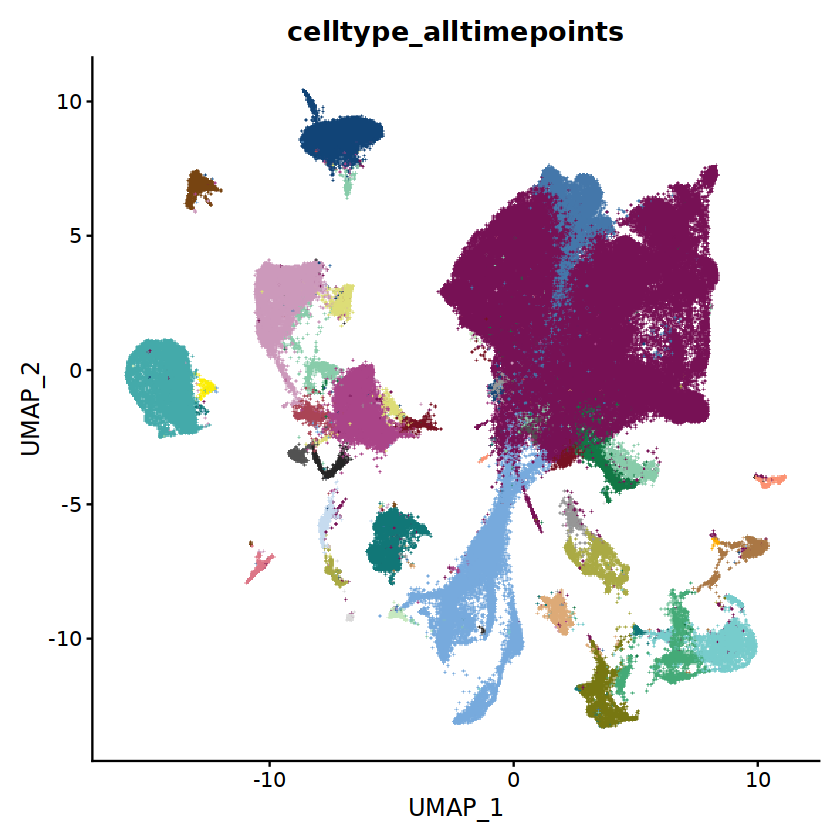

In [6]:
Idents(dat) <- 'seurat_clusters'

dat <- RenameIdents(object = dat,
                    '0' = 'NB',
                    '1' = 'NB',
                    '2' = 'NB',
                    '3' = 'T_NK_cells',
                    '4' = 'NB',
                    '5' = 'NB',
                    '6' = 'Macrophages',
                    '7' = 'NB',
                    '8' = 'NB',
                    '9' = 'B_cells',
                    '10' = 'NB_heatshock',
                    '11' = 'NB',
                    '12' = 'NB',
                    '13' = 'NB',
                    '14' = 'Erythrocytes',
                    '15' = 'Fibroblasts',
                    '16' = 'NB',
                    '17' = 'Neutrophils',
                    '18' = 'NB',
                    '19' = 'NB',
                    '20' = 'Erythrocytes',
                    '21' = 'NB',
                    '22' = 'NB',
                    '23' = 'Neuronal',
                    '24' = 'Neutrophils',
                    '25' = 'NB',
                    '26' = 'NB_cycling',
                    '27' = 'Radial_glia',
                    '28' = 'NB_heatshock',
                    '29' = 'NB_withBloodProgen',
                    '30' = 'NB',
                    '31' = 'Mesenchymal_cells',
                    '32' = 'Epithelial_cells',
                    '33' = 'NB',
                    '34' = 'NB',
                    '35' = 'Macrophages_myeloid_NKL_cells',
                    '36' = 'Mucin_cells',
                    '37' = 'NB',
                    '38' = 'Glial_sox10',
                    '39' = 'NB',
                    '40' = 'NB',
                    '41' = 'Endothelial_cells',
                    '42' = 'Erythrocytes',
                    '43' = 'NK_cells_and_doublets',
                    '44' = 'Blood_progenitors',
                    '45' = 'Interrenal_cells',
                    '46' = 'Erythrocytes',
                    '47' = 'Th2_cells_NB_mix',
                    '48' = 'NB_epithelial_mix?',
                    '49' = 'Erythrocytes',
                    '50' = 'T_cells',
                    '51' = 'NB',
                    '52' = 'Kidney_tubule',
                    '53' = 'NB',
                    '54' = 'Epithelial_cells',
                    '55' = 'Hepato_enterocytes',
                    '56' = 'NB',
                    '57' = 'HSPCs',
                    '58' = 'B_cells',
                    '59' = 'Muscle_cells',
                    '60' = 'Neuronal',
                    '61' = 'Fibroblasts',
                    '62' = 'Neutrophils_withSomeEry',
                    '63' = 'Pigment_cells'
                    )
# Save to metadata
dat$celltype_alltimepoints <- Idents(dat)

# Plot
DimPlot(object = dat, reduction = 'umap', pt.size = 0.5, group.by = "celltype_alltimepoints", cols = tol21rainbow, shuffle = T)
DimPlot(object = dat, reduction = 'umap', pt.size = 0.5, group.by = "celltype_alltimepoints", cols = tol21rainbow, shuffle = T) + NoLegend()


#### Plot primary tumor cell types and sample type fraction per cluster

In [7]:
# Add cell type assignments from primary tumors and controls to object
metadata_pts_small <- metadata_pts[,c('celltype_overall','location','genotype','Barcode_pts')]
rownames(metadata_pts_small) <- paste0('pts_', metadata_pts_small$Barcode_pts)
metadata_pts_small$Barcode <- rownames(metadata_pts_small) 

metadata_alltps <- dat@meta.data
metadata_alltps$Barcode <- rownames(metadata_alltps)

In [8]:
metadata_alltps_ext <- left_join(metadata_alltps, metadata_pts_small, by = 'Barcode')
rownames(metadata_alltps_ext) <- metadata_alltps_ext$Barcode

table(rownames(metadata_alltps_ext) == rownames(dat@meta.data))


  TRUE 
208658 

In [9]:
# If the above rownames match (100 % TRUE), add extended metadata back to Seurat object.
dat@meta.data <- metadata_alltps_ext

In [10]:
# Add sample type info

dat@meta.data$sample_type <- 'late_allograft'
dat@meta.data$sample_type[rownames(dat@meta.data) %like any% 'pts_%'] <- 'primary_tumor'
dat@meta.data$sample_type[(rownames(dat@meta.data) %like any% 'pts_%') & dat@meta.data$location == 'control'] <- 'ctrl_head_kidney'
dat@meta.data$sample_type[rownames(dat@meta.data) %like any% 'ea_%'] <- 'early_allograft'


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



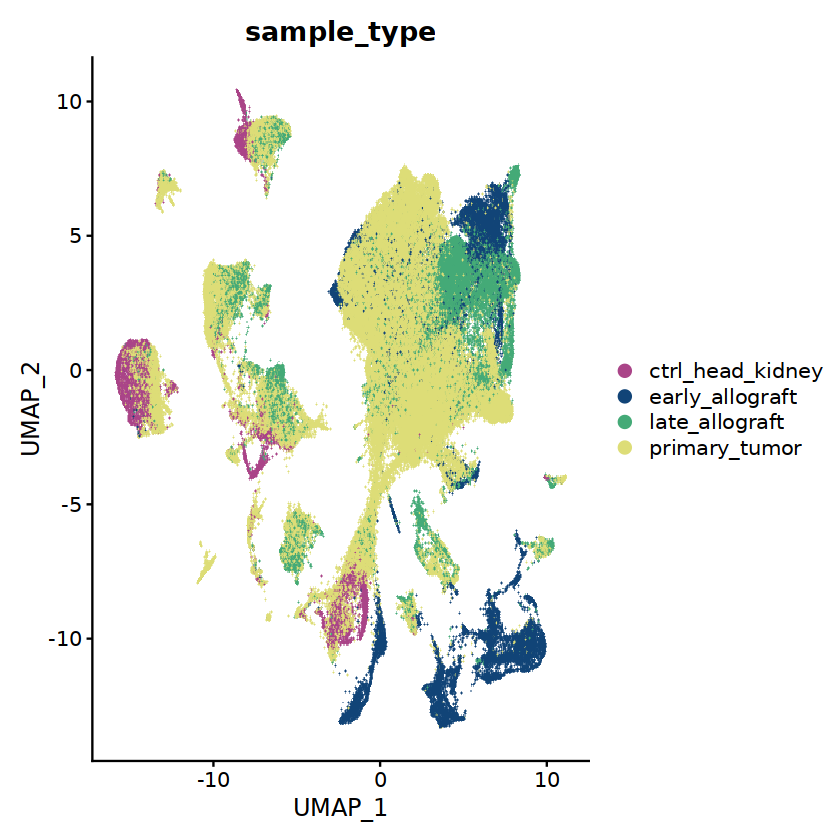

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



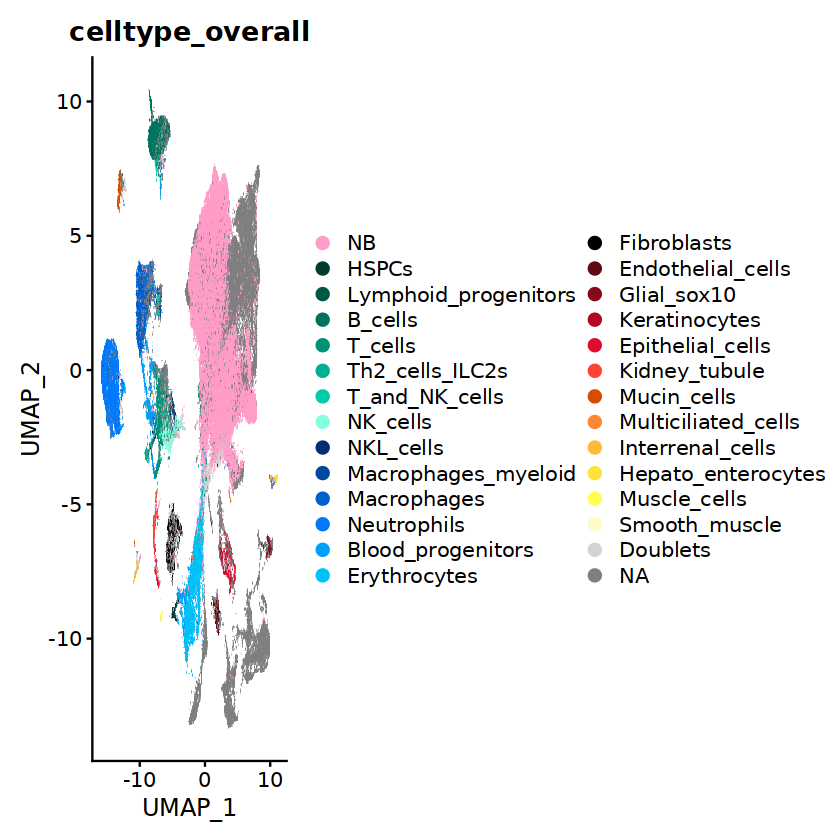

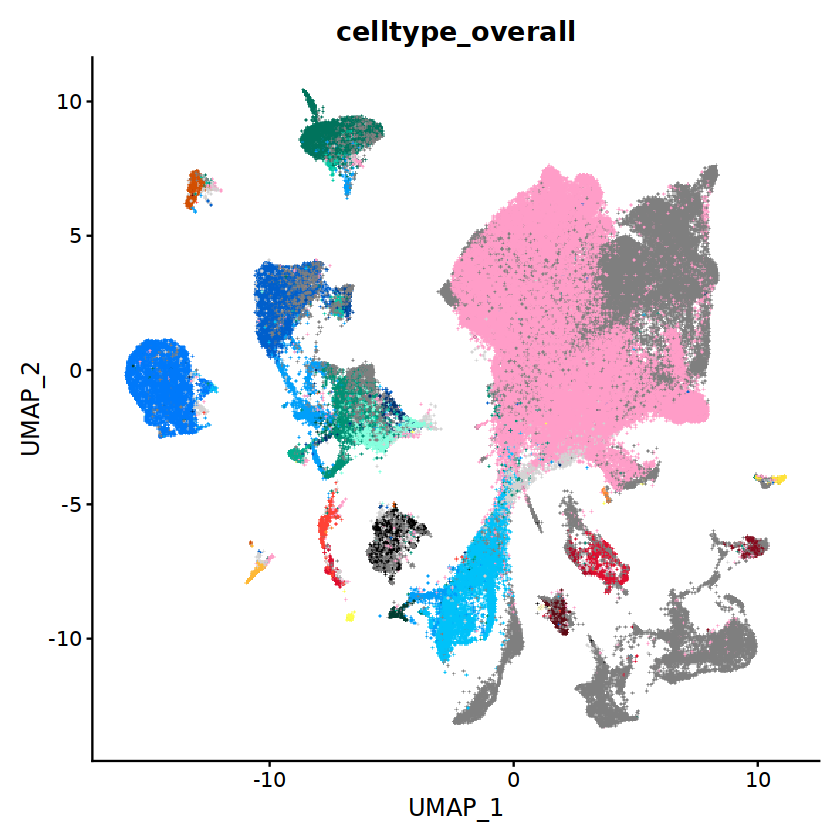

In [11]:
library(RColorBrewer)
n <- length(unique(dat@meta.data$seurat_clusters))
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector_det = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))
col_vector_det=sample(col_vector_det, n)

DimPlot(object = dat, reduction = 'umap', pt.size = 0.5, group.by = "sample_type", cols = tol21rainbow[c(2,4,11,15)], shuffle = T)

dat$celltype_overall <- factor(as.character(dat$celltype_overall),
                               levels = c('NB',
                                        'HSPCs',
                                        'Lymphoid_progenitors',
                                        'B_cells',
                                        'T_cells',
                                        'Th2_cells_ILC2s',
                                        'T_and_NK_cells',
                                        'NK_cells',
                                        'NKL_cells',
                                        'Macrophages_myeloid',
                                        'Macrophages',
                                        'Neutrophils',
                                        'Blood_progenitors',
                                        'Erythrocytes',
                                        'Fibroblasts',
                                        'Endothelial_cells',
                                        'Glial_sox10',
                                        'Keratinocytes',
                                        'Epithelial_cells',
                                        'Kidney_tubule',
                                        'Mucin_cells',
                                        'Multiciliated_cells',
                                        'Interrenal_cells',
                                        'Hepato_enterocytes',
                                        'Muscle_cells',
                                        'Smooth_muscle',
                                        'Doublets'
                                        )
                                    )

DimPlot(object = dat, reduction = 'umap', pt.size = 0.5, group.by = "celltype_overall", cols = c(colorblindfriend24_var[c(7,1:6,8:14)],colorblindfriend24_var[17:length(colorblindfriend24_var)],'light grey'), shuffle = T)
DimPlot(object = dat, reduction = 'umap', pt.size = 0.5, group.by = "celltype_overall", cols = c(colorblindfriend24_var[c(7,1:6,8:14)],colorblindfriend24_var[17:length(colorblindfriend24_var)],'light grey'), shuffle = T) + NoLegend()


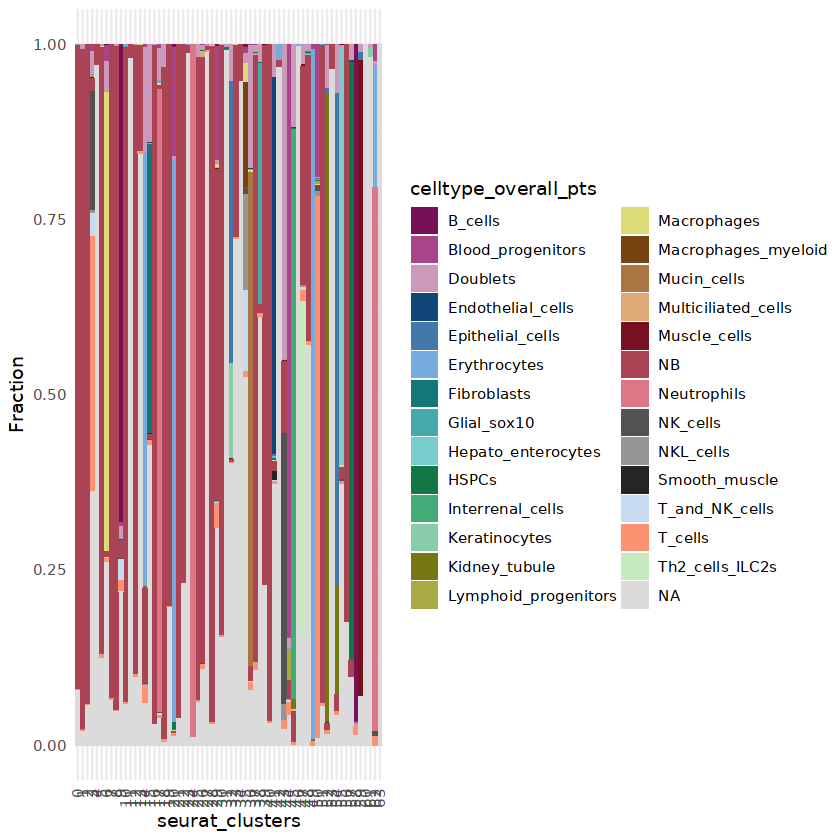

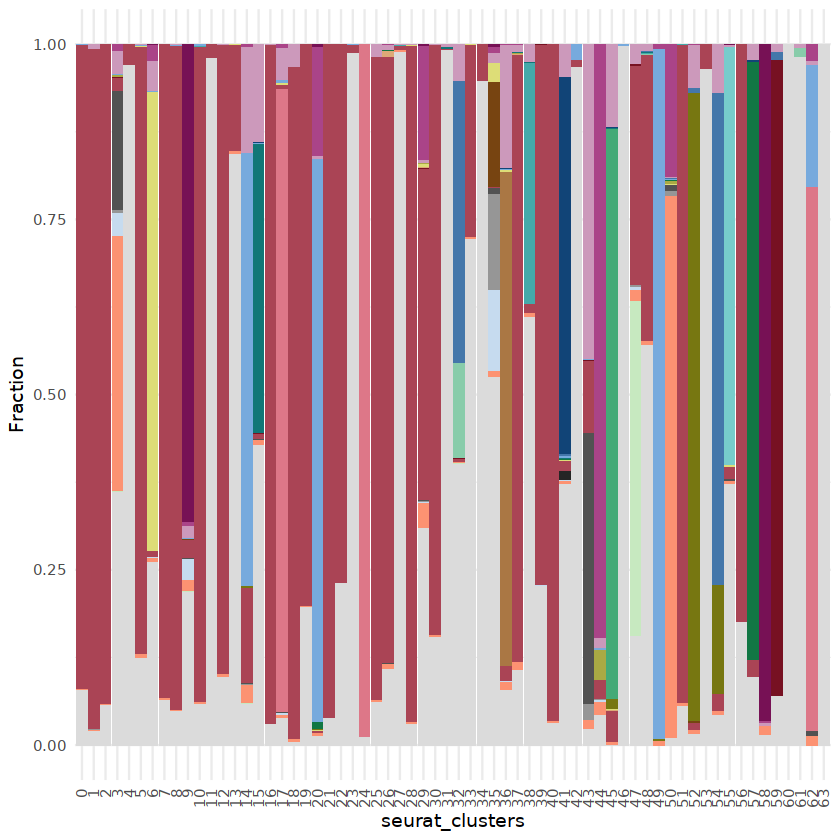

In [79]:
# Plot primary tumor cell type assignments per cluster
# While considering NAs in the fraction (i.e. cells from allograft samples)
dat$celltype_plot <- as.character(dat$celltype_overall)
dat$celltype_plot[is.na(dat$celltype_plot)] <- 'NA'
comp_table <- as.data.frame(table(dat$seurat_clusters, dat$celltype_plot))
comp_table <- comp_table[comp_table$Freq != 0,]
colnames(comp_table) <- c('seurat_clusters','celltype_overall_pts','Fraction')

comp_table$celltype_overall_pts <- factor(as.character(comp_table$celltype_overall_pts),
                               levels = c(unique(as.character(comp_table$celltype_overall_pts))[c(unique(as.character(comp_table$celltype_overall_pts))) != 'NA'], 'NA'))

ggplot(comp_table, aes(fill=celltype_overall_pts, y=Fraction, x=seurat_clusters)) + 
    geom_bar(position="fill", stat="identity") +
    theme_minimal() +
    scale_fill_manual(values = c(tol21rainbow[1:32],'#F4F4F4')) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

ggplot(comp_table, aes(fill=celltype_overall_pts, y=Fraction, x=seurat_clusters)) + 
    geom_bar(position="fill", stat="identity") +
    theme_minimal() +
    scale_fill_manual(values = c(tol21rainbow[1:32],'#F4F4F4')) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), legend.position = "none")

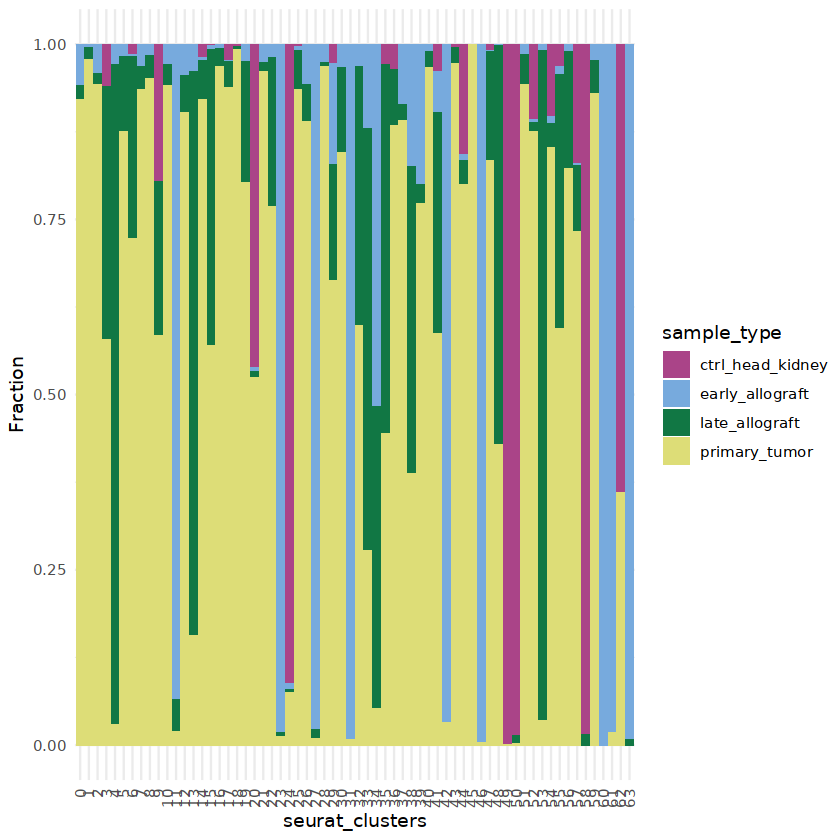

In [81]:
# Plot sample type assignments per cluster
comp_table <- as.data.frame(table(dat$sample_type, dat$seurat_clusters))
comp_table <- comp_table[comp_table$Freq != 0,]
colnames(comp_table) <- c('sample_type','seurat_clusters','Fraction')


ggplot(comp_table, aes(fill=sample_type, y=Fraction, x=seurat_clusters)) + 
    geom_bar(position="fill", stat="identity") +
    theme_minimal() +
    scale_fill_manual(values = tol21rainbow[c(2,6,10,15)]) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


#### Assign cell types with SingleR

In [ ]:
# SinlgeR with aggregated celltype references
# load SingleR reference
load("../data/allmerged_final_celltypeOverall_withoutDoublets_singlR_ref.Robj")

pred_name <- "PTs_final_CTsOverall_withoutDoublets"

# prepare data and run SingleR
scTest <- as.SingleCellExperiment(dat)
pred.grun <- SingleR(test=assay(scTest, "logcounts"), ref=singlR_ref_data, labels = colnames(singlR_ref_data))

save(pred.grun, file = paste0(dat_name,"_",pred_name,"_singleR_predictions.Robj"))
rm(singlR_ref_data)
rm(scTest)


In [12]:
## Reload results and remove uncertain labels
pred_name <- "PTs_final_CTsOverall_withoutDoublets"

load(paste0("./data_allTPs/",dat_name,"_",pred_name,"_singleR_predictions.Robj"))

# Remove uncertain labels!
pred.grun$prune_survive <- pruneScores(
                                pred.grun,
                                nmads = 2,
                                min.diff.med = 0.01,
                                min.diff.next = 0.02,
                                get.thresholds = F
                            )

pred.grun$pruned.labels[pred.grun$prune_survive == T] <- NA



In [13]:
# Add predictions to seurat object
metadat <- dat@meta.data
metadat$Barcode <- rownames(metadat)
label_df <- as.data.frame(pred.grun[,c("labels","pruned.labels")])
label_df$Barcode <- rownames(label_df)

metadat_ext <- left_join(metadat, label_df, by = 'Barcode')
rownames(metadat_ext) <- metadat_ext$Barcode

table(rownames(metadat_ext) == rownames(dat@meta.data))


  TRUE 
208658 

In [14]:
# If the above row names match (100 % TRUE), add extended metadata object back to Seurat object.
dat@meta.data <- metadat_ext

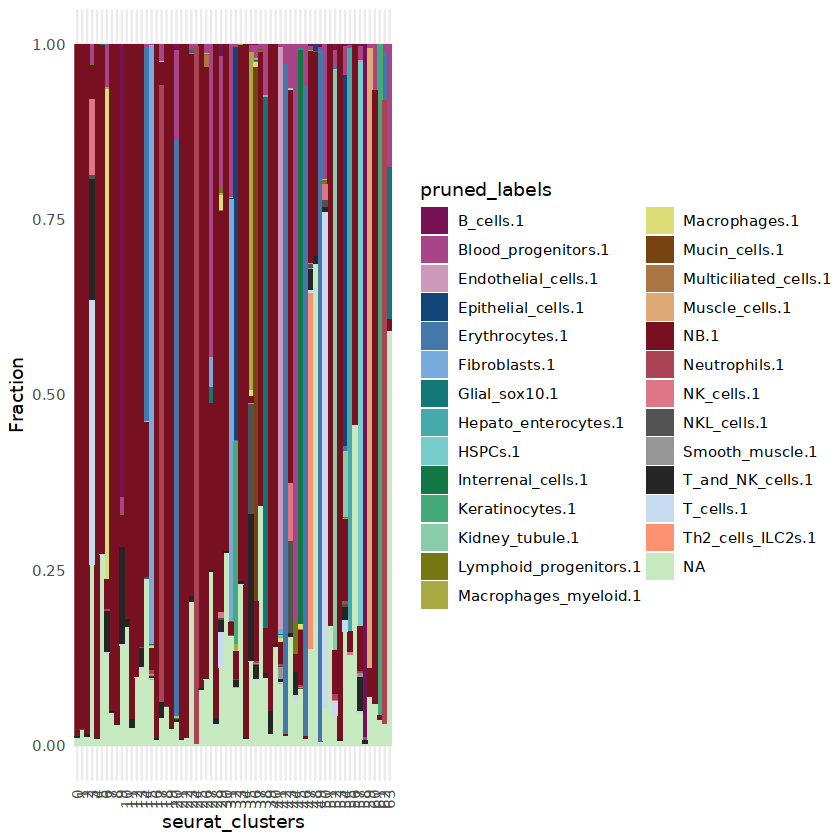

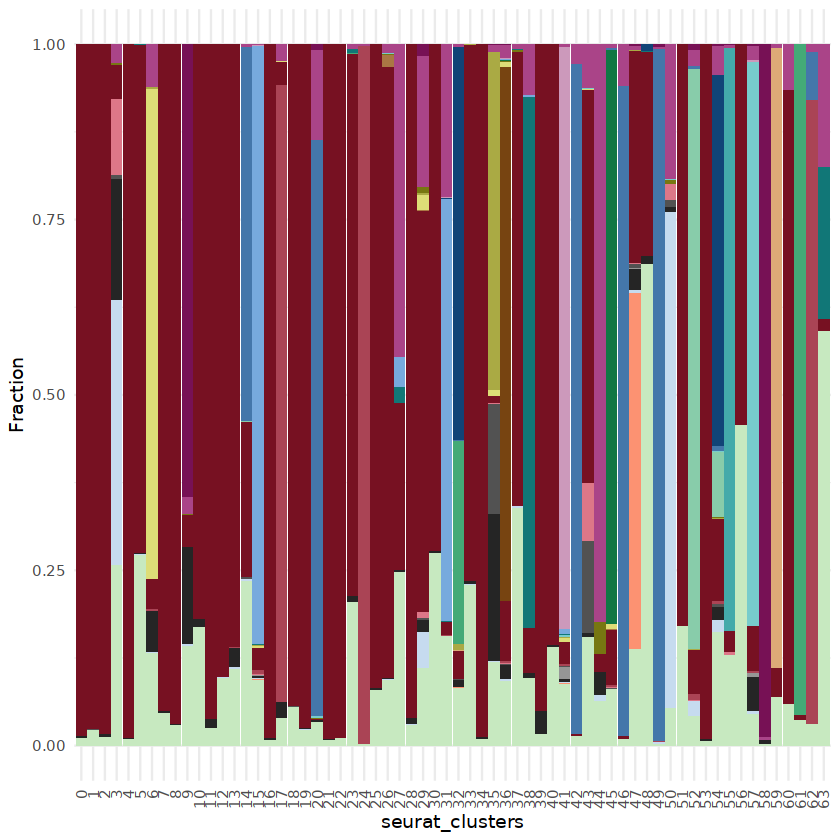

In [30]:
# Plot pruned labels per cluster
dat$label_plot <- as.character(dat$pruned.labels)
dat$label_plot[is.na(dat$label_plot)] <- 'NA' # Make sure NAs are set as a character, so that they are considered in the plot.
comp_table <- as.data.frame(table(dat$seurat_clusters, dat$label_plot))
comp_table <- comp_table[comp_table$Freq != 0,]
colnames(comp_table) <- c('seurat_clusters','pruned_labels','Fraction')

comp_table$pruned_labels <- factor(as.character(comp_table$pruned_labels),
                               levels = c(unique(as.character(comp_table$pruned_labels))[c(unique(as.character(comp_table$pruned_labels))) != 'NA'], 'NA'))

ggplot(comp_table, aes(fill=pruned_labels, y=Fraction, x=seurat_clusters)) + 
    geom_bar(position="fill", stat="identity") +
    theme_minimal() +
    scale_fill_manual(values = c(tol21rainbow[1:32],'#F4F4F4')) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

ggplot(comp_table, aes(fill=pruned_labels, y=Fraction, x=seurat_clusters)) + 
    geom_bar(position="fill", stat="identity") +
    theme_minimal() +
    scale_fill_manual(values = c(tol21rainbow[1:32],'#F4F4F4')) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), legend.position = 'none')

#### Assign final celltypes based on primary tumor class and new findings
**Rationale:**  
- Primary tumor and control cells that were previously annotated keep their cell type assignments.  
- Early and late allograft cells are annotated according to SingleR-assigned cell type labels.  
- Individual cluster assignments are cross-referenced with cluster markers and cell type marker gene expression scores plotted above. Based on this, individual misassigned clusters are re-named.

In [15]:
dat@meta.data$ct_final <- as.character(dat@meta.data$celltype_alltimepoints)
dat@meta.data$ct_final[!dat@meta.data$sample_type %in% c('primary_tumor','ctrl_head_kidney')] <- gsub("\\..*","",dat@meta.data$pruned.labels[!dat@meta.data$sample_type %in% c('primary_tumor','ctrl_head_kidney')])
dat@meta.data$ct_final[dat@meta.data$sample_type == 'late_allograft' & is.na(dat@meta.data$ct_final)] <- 'Doublets'
dat@meta.data$ct_final[dat@meta.data$sample_type == 'early_allograft' & is.na(dat@meta.data$ct_final)] <- as.character(dat@meta.data$celltype_alltimepoints[dat@meta.data$sample_type == 'early_allograft' & is.na(dat@meta.data$ct_final)])
dat@meta.data$ct_final[dat@meta.data$sample_type == 'primary_tumor'] <- as.character(dat@meta.data$celltype_overall[dat@meta.data$sample_type == 'primary_tumor'])
dat@meta.data$ct_final[dat@meta.data$sample_type == 'ctrl_head_kidney'] <- as.character(dat@meta.data$celltype_overall[dat@meta.data$sample_type == 'ctrl_head_kidney'])

dat@meta.data$ct_final[dat@meta.data$seurat_clusters %in% c('23','60')] <- 'Neuronal'
dat@meta.data$ct_final[dat@meta.data$seurat_clusters == '63'] <- 'Pigment_cells'
dat@meta.data$ct_final[dat@meta.data$seurat_clusters == '27'] <- 'Radial_glia'
dat@meta.data$ct_final[dat@meta.data$seurat_clusters == '38'] <- 'Glial_sox10'
dat@meta.data$ct_final[dat@meta.data$seurat_clusters == '31' & dat@meta.data$sample_type != 'primary_tumor'] <- 'Mesenchymal_cells'
dat@meta.data$ct_final[dat@meta.data$seurat_clusters == '35' & dat@meta.data$ct_final != 'Doublets'] <- 'Macrophages_myeloid_NKL_cells'
dat@meta.data$ct_final[dat@meta.data$seurat_clusters == '9' & dat@meta.data$ct_final != 'Doublets'] <- 'B_cells'
dat@meta.data$ct_final[dat@meta.data$seurat_clusters == '13' & dat@meta.data$ct_final != 'Doublets' & dat@meta.data$sample_type != 'primary_tumor'] <- 'NB'

dat@meta.data$ct_final[dat@meta.data$ct_final  == 'Erythrocytes' & dat@meta.data$seurat_clusters == '62'] <- 'Doublets'

dat@meta.data$ct_final[dat@meta.data$ct_final  %in% c('NB_withBloodProgen','NB_cycling','NB_heatshock') ] <- 'NB'
dat@meta.data$ct_final[dat@meta.data$ct_final  %in% c('NB_epithelial_mix?') ] <- 'Epithelial_cells'
dat@meta.data$ct_final[dat@meta.data$ct_final  %in% c('T_NK_cells') ] <- 'T_and_NK_cells'


In [16]:
# Re-order cell types in factor according to desired plot order.
# In this case, this is pre-defined in the palette vector used for plotting.
dat$ct_final <- as.character(dat$ct_final)
dat$ct_final <- factor(dat$ct_final, levels = names(alltimepointsmerged_final_ct_cols))


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



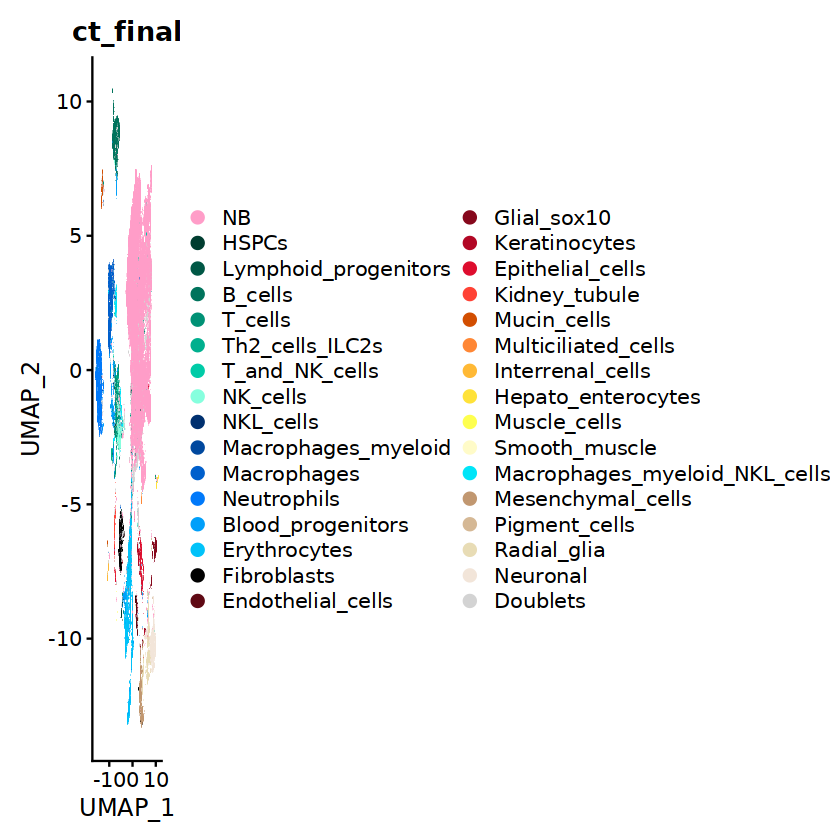

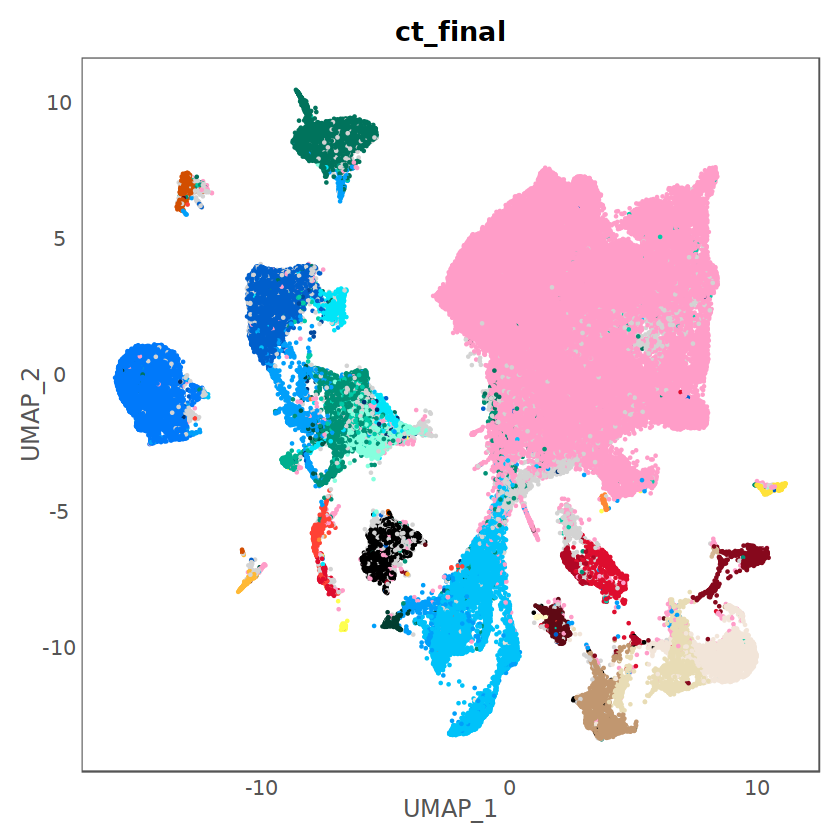

In [17]:

# Plot
DimPlot(object = dat, reduction = 'umap', pt.size = 0.5, group.by = "ct_final", cols = alltimepointsmerged_final_ct_cols, shuffle = T)

DimPlot(object = dat, reduction = 'umap', pt.size = 0.25, group.by = "ct_final", cols = alltimepointsmerged_final_ct_cols, shuffle = T, raster=FALSE) +
                NoAxes() +
                NoLegend() +
                mytheme_angledYtitle

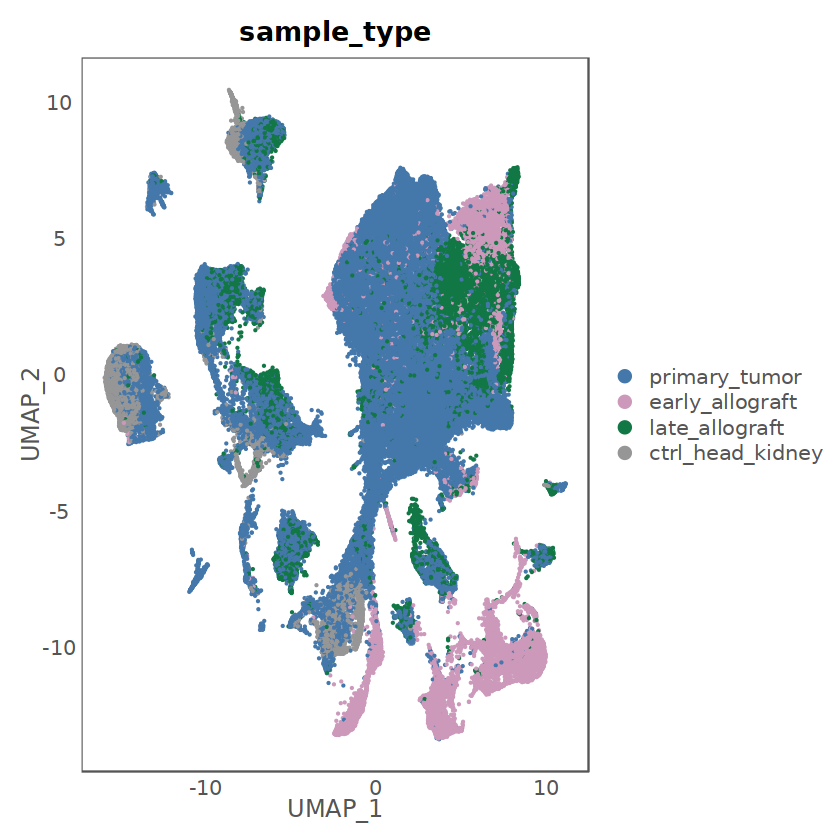

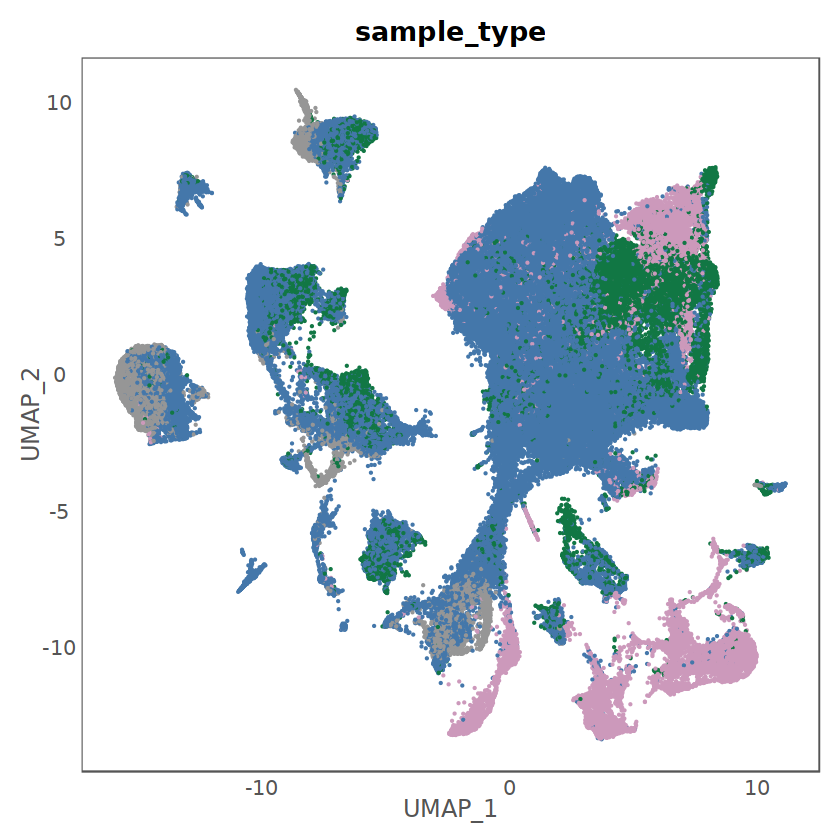

In [40]:
dat$sample_type <- factor(as.character(dat$sample_type), levels = c('primary_tumor','early_allograft','late_allograft','ctrl_head_kidney'))

DimPlot(object = dat, reduction = 'umap', pt.size = 0.15, group.by = "sample_type", cols = tol21rainbow[c(5,3,10,23)], shuffle = T, raster=FALSE) +
                     NoAxes() +
                     mytheme_angledYtitle

DimPlot(object = dat, reduction = 'umap', pt.size = 0.15, group.by = "sample_type", cols = tol21rainbow[c(5,3,10,23)], shuffle = T, raster=FALSE) +
                NoAxes() +
                NoLegend() +
                mytheme_angledYtitle

##### Plot new cell type assignments per sample and sample type

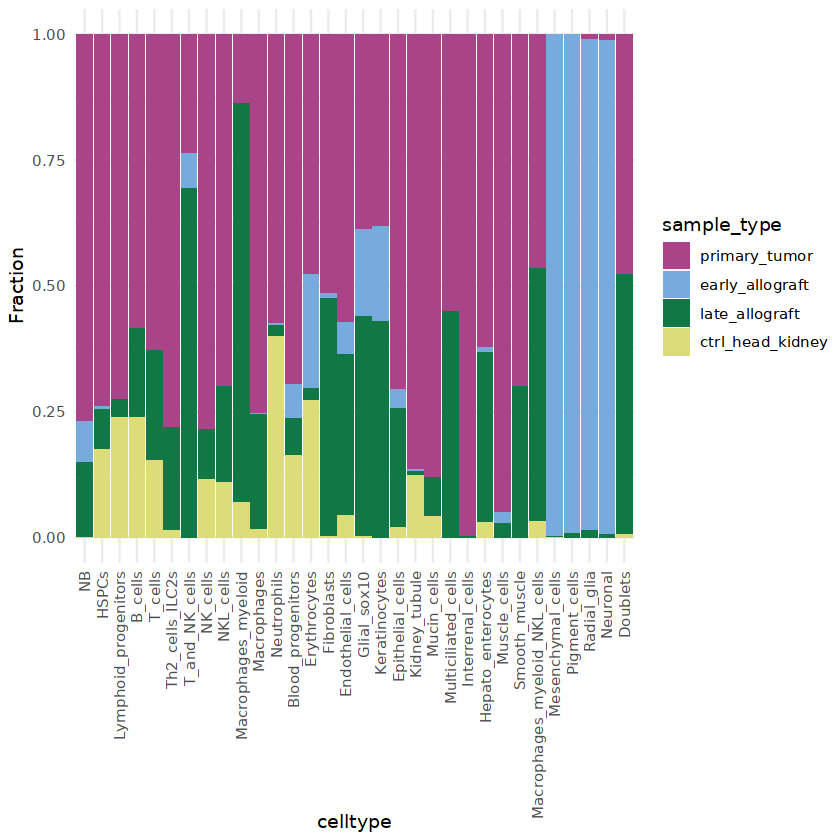

In [44]:
comp_table <- as.data.frame(table(dat$sample_type, dat$ct_final))
comp_table <- comp_table[comp_table$Freq != 0,]
colnames(comp_table) <- c('sample_type','celltype','Fraction')

ggplot(comp_table, aes(fill=sample_type, y=Fraction, x=celltype)) + 
    geom_bar(position="fill", stat="identity") +
    theme_minimal() +
    scale_fill_manual(values = tol21rainbow[c(2,6,10,15)]) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

## Get cell type markers and plot dotplot

In [ ]:
Idents(dat)<- "ct_final"

# Find celltype markers:
markers_all <- FindAllMarkers(object = dat, only.pos = TRUE, min.pct = 0.4, logfc.threshold = 0.7)
write.csv(markers_all, file = paste0("ctFinalMarkerGenes_",dat_name,"_minpct40_logfct_70.csv"))


In [49]:
# Dotplot with marker genes for celltypes
markers_cts <- read.delim(paste0("celltype_assign_files_allTPs/ctFinalMarkerGenes_",dat_name,"_minpct40_logfct_70.csv"), stringsAsFactors = F, sep = ',', row.names = 1)
markers_cts %>% group_by(cluster) %>% top_n(n = 4, wt = avg_log2FC) -> top6
top6 <- as.data.frame(top6)
rownames(top6) <- paste0('gene_',c(1:nrow(top6)))
top6ord <- top6[order(top6$avg_log2FC, decreasing = T),]
top6ord <- top6ord[duplicated(top6ord$gene) == F,]

top6 <- top6[rownames(top6) %in% rownames(top6ord),]
top6 %>% group_by(cluster) %>% top_n(n = 4, wt = avg_log2FC) -> top4

top6 %>% group_by(cluster) %>% top_n(n = 1, wt = avg_log2FC) -> top1


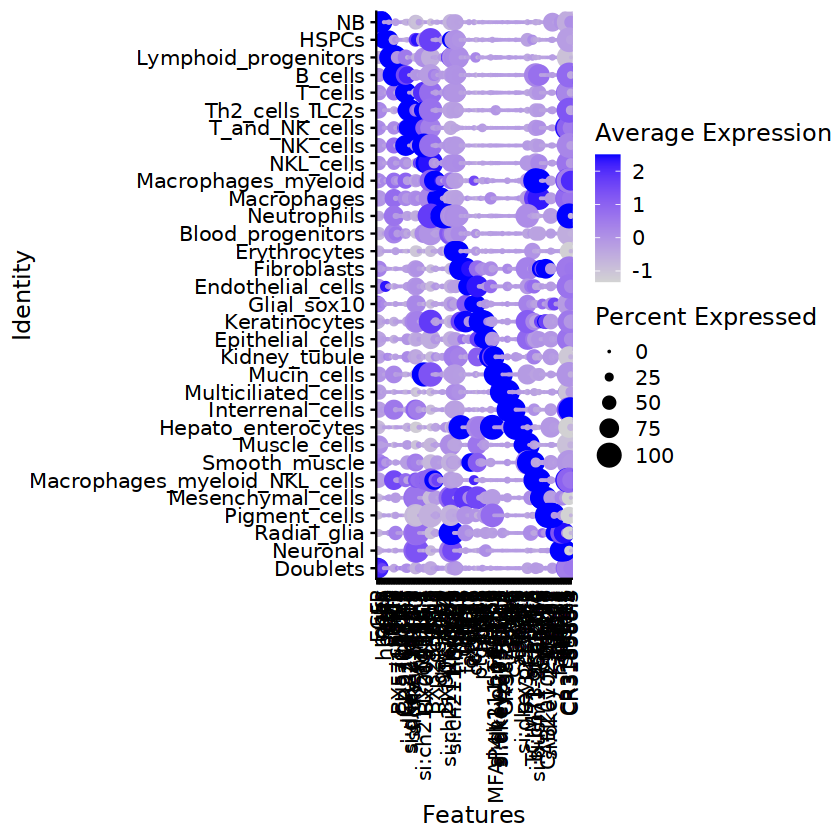

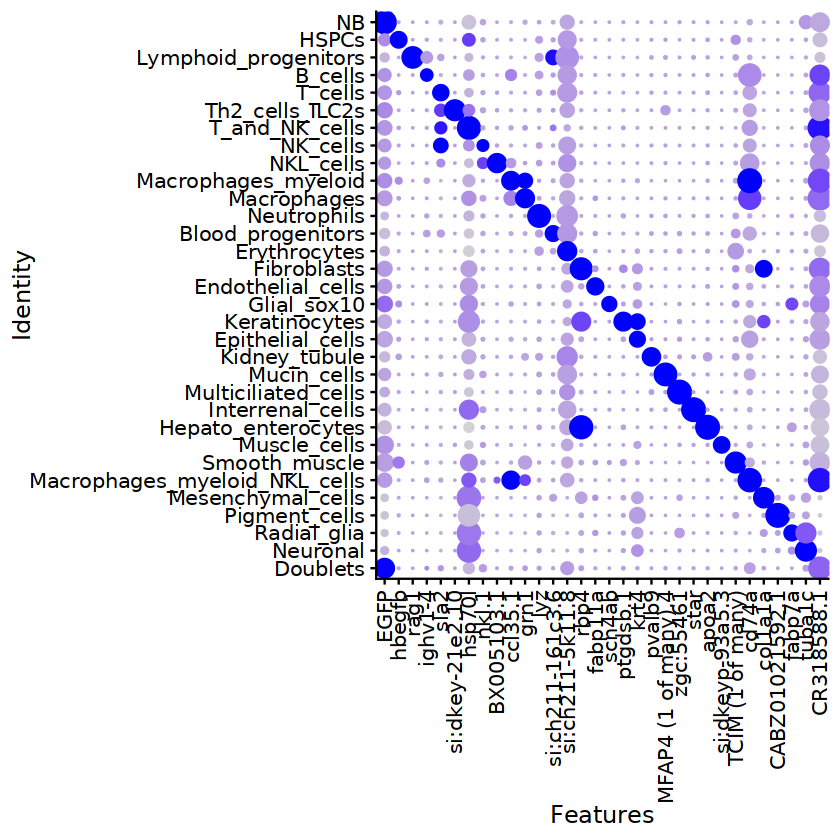

In [50]:
# RENAME LEVELS
dat$ct_final <- factor(dat$ct_final, levels = rev(c('NB',
                                                    'HSPCs',
                                                    'Lymphoid_progenitors',
                                                    'B_cells',
                                                    'T_cells',
                                                    'Th2_cells_ILC2s',
                                                    'T_and_NK_cells',
                                                    'NK_cells',
                                                    'NKL_cells',
                                                    'Macrophages_myeloid',
                                                    'Macrophages',
                                                    'Neutrophils',
                                                    'Blood_progenitors',
                                                    'Erythrocytes',
                                                    'Fibroblasts',
                                                    'Endothelial_cells',
                                                    'Glial_sox10',
                                                    'Keratinocytes',
                                                    'Epithelial_cells',
                                                    'Kidney_tubule',
                                                    'Mucin_cells',
                                                    'Multiciliated_cells',
                                                    'Interrenal_cells',
                                                    'Hepato_enterocytes',
                                                    'Muscle_cells',
                                                    'Smooth_muscle',
                                                    'Macrophages_myeloid_NKL_cells',
                                                    'Mesenchymal_cells',
                                                    'Pigment_cells',
                                                    'Radial_glia',
                                                    'Neuronal',
                                                    'Doublets'
                                        ))
                                    )


DotPlot(dat, features = top4$gene, group.by = 'ct_final') +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

DotPlot(dat, features = top1$gene, group.by = 'ct_final') +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), legend.position = 'none')

## Add further metadata

In [ ]:
# Load Seurat object
load(paste0(dat_name,"_clustered.Robj"))

In [24]:
# Load sample metadata table
samp_inf <- read.delim('samp_metadata_allTPs.csv',stringsAsFactors = F, sep = ';')

In [21]:
# Remove metadata columns that will be introduced by the sample metadata file to avoid duplication
dat@meta.data <- dat@meta.data[,!(colnames(dat@meta.data) %in% colnames(samp_inf))]

colnames(dat@meta.data)

[1] "Barcode"                "orig.ident"             "nCount_RNA"            
 [4] "nFeature_RNA"           "percent.mt"             "cons_class"            
 [7] "RNA_snn_res.1.4"        "seurat_clusters"        "celltype_alltimepoints"
[10] "celltype_overall"       "Barcode_pts"            "sample_type"           
[13] "labels"                 "pruned.labels"          "ct_final"

In [22]:
# Generate a column for merging the data with the metadata. This needs to contain info about the dataset and MULTI-seq barcodes assigned.
dat@meta.data$sample_id <- dat@meta.data$orig.ident
dat@meta.data$sample_id[dat@meta.data$orig.ident %in% c("multi_seq_2_s1","multi_seq_2_s2")] <- paste0("multi_seq_2_",dat@meta.data$cons_class[dat@meta.data$orig.ident %in% c("multi_seq_2_s1","multi_seq_2_s2")])
dat@meta.data$sample_id[dat@meta.data$orig.ident %in% c("multi_seq_3_s1","multi_seq_3_s2")] <- paste0("multi_seq_3_",dat@meta.data$cons_class[dat@meta.data$orig.ident %in% c("multi_seq_3_s1","multi_seq_3_s2")])
dat@meta.data$sample_id[dat@meta.data$orig.ident %in% c("multi_4_allo1_1","multi_4_allo1_2")] <- paste0("multi_seq_4_",dat@meta.data$cons_class[dat@meta.data$orig.ident %in% c("multi_4_allo1_1","multi_4_allo1_2")])
dat@meta.data$sample_id[dat@meta.data$orig.ident == "multi_allos_1_tum"] <- paste0("multi_allos_1_tum_",dat@meta.data$cons_class[dat@meta.data$orig.ident == "multi_allos_1_tum"])
dat@meta.data$sample_id[dat@meta.data$orig.ident == "multi_bAllos_1_tum"] <- dat@meta.data$cons_class[dat@meta.data$orig.ident == "multi_bAllos_1_tum"]
dat@meta.data$sample_id[dat@meta.data$orig.ident == "multi_bAllos_2_tum"] <- paste0("multi_bAllos_2_tum_",dat@meta.data$cons_class[dat@meta.data$orig.ident == "multi_bAllos_2_tum"])

dat@meta.data$sample_id[dat@meta.data$orig.ident == "multi_bAllos_3_tum"] <-paste0("multi_bAllos_3_tum_",dat@meta.data$cons_class[dat@meta.data$orig.ident == "multi_bAllos_3_tum"])

dat@meta.data$sample_id[dat@meta.data$orig.ident %in% c("multi_bAllos_4_PTs_S1","multi_bAllos_4_PTs_S2")] <-paste0("multi_bAllos_4_tum_",dat@meta.data$cons_class[dat@meta.data$orig.ident %in% c("multi_bAllos_4_PTs_S1","multi_bAllos_4_PTs_S2")])
dat@meta.data$sample_id[dat@meta.data$orig.ident %in% c("multiseq_17_S1","multiseq_17_S2")] <-paste0("multi_seq_17_",dat@meta.data$cons_class[dat@meta.data$orig.ident %in% c("multiseq_17_S1","multiseq_17_S2")])


dat@meta.data$sample_id[dat@meta.data$orig.ident == "multi_lateAllos_1"] <-paste0("multi_lateAllos_1_",dat@meta.data$cons_class[dat@meta.data$orig.ident == "multi_lateAllos_1"])
dat@meta.data$sample_id[dat@meta.data$orig.ident == "multi_allos_1_allos"] <-paste0("multi_allos_1_allos_",dat@meta.data$cons_class[dat@meta.data$orig.ident == "multi_allos_1_allos"])
dat@meta.data$sample_id[dat@meta.data$orig.ident == "multi_bAllos_1_allos"] <- dat@meta.data$cons_class[dat@meta.data$orig.ident == "multi_bAllos_1_allos"]
dat@meta.data$sample_id[dat@meta.data$orig.ident == "multi_bAllos_2_lateAllos"] <-paste0("multi_bAllos_2_lateAllos_",dat@meta.data$cons_class[dat@meta.data$orig.ident == "multi_bAllos_2_lateAllos"])
dat@meta.data$sample_id[dat@meta.data$orig.ident == "multi_bAllos_3_allos"] <-paste0("multi_bAllos_3_allos_",dat@meta.data$cons_class[dat@meta.data$orig.ident == "multi_bAllos_3_allos"])
dat@meta.data$sample_id[dat@meta.data$orig.ident == "multi_bAllos_4_allos"] <-paste0("multi_bAllos_4_allos_",dat@meta.data$cons_class[dat@meta.data$orig.ident == "multi_bAllos_4_allos"])

dat@meta.data$sample_id[dat@meta.data$orig.ident  %in% c("multi_bAllos_4_lateAllos_S1","multi_bAllos_4_lateAllos_S2")] <-paste0("multi_bAllos_4_lateAllos_",dat@meta.data$cons_class[dat@meta.data$orig.ident %in% c("multi_bAllos_4_lateAllos_S1","multi_bAllos_4_lateAllos_S2")])
dat@meta.data$sample_id[dat@meta.data$orig.ident %in% c("multi_bAllos_4_lateAllos_02_S2")] <-paste0("multi_bAllos_4_lateAllos_02_",dat@meta.data$cons_class[dat@meta.data$orig.ident %in% c("multi_bAllos_4_lateAllos_02_S2")])


dat@meta.data$sample_id[dat@meta.data$orig.ident == "mycn_tum_01"] <- "MYCN_EGFP_1"
dat@meta.data$sample_id[dat@meta.data$orig.ident == "mycn_tum_02"] <- "MYCN_1"
dat@meta.data$sample_id[dat@meta.data$orig.ident == "mycnbirc5_tum"] <- "MYCN_BIRC5_1"
dat@meta.data$sample_id[dat@meta.data$orig.ident == "mycnlmo1_ventral_tum"] <- "MYCN_LMO1_vent_1_1"
dat@meta.data$sample_id[dat@meta.data$orig.ident == "mycnlmo1_kidney_tum"] <- "MYCN_LMO1_lat_1_1"
dat@meta.data$sample_id[dat@meta.data$orig.ident == "healthyhk_ctrl"] <- "EGFP_ctrl_1"
dat@meta.data$sample_id[dat@meta.data$orig.ident == "lmo1_ctrl"] <- "LMO1_ctrl_1"
dat@meta.data$sample_id[dat@meta.data$orig.ident == "mycn_tum_04"] <- "MYCN_2"
dat@meta.data$sample_id[dat@meta.data$orig.ident == "multi_seq_1_dr_tum"] <- "multi_seq_1_MYCNLMO1"


In [25]:
table(dat@meta.data$sample_id %in% samp_inf$sample_id)
table(samp_inf$sample_id %in% dat@meta.data$sample_id)

# All sample-IDs match!


  TRUE 
208658 


TRUE 
 151 

character(0)

character(0)

In [26]:
# Merge
dat@meta.data$cellid <- rownames(dat@meta.data)

metadat_ext <- left_join(dat@meta.data, samp_inf, by = 'sample_id')
rownames(metadat_ext) <- metadat_ext$cellid

table(rownames(metadat_ext) == rownames(dat@meta.data))


  TRUE 
208658 

In [28]:
# If the above rownames match (100 % TRUE), add extended metadata back to Seurat object.
dat@meta.data <- metadat_ext

In [36]:
# Summarize allograft tumor locations
dat$location_sum <- dat$location
dat$location_sum[dat$location_sum %in% c('behind_eye','behind_eye_towards_brain','behind_left_eye','behind_right_eye')] <- 'eye_orbit'
dat$location_sum[dat$location_sum %in% c('behind_eye_within_cartilage','head_bone')] <- 'cranial_bone_cartilage'
dat$location_sum[dat$location_sum %in% c('digestive_tract','lateral_slightly_ventral', 'mixed', 'spread_out','tail_within_muscle','ventral_cartilage',
                                          'ventral_further_back','ventral_mixed','ventral_posterior','dorsal','towards_ventral','close_to_skull_roof')] <- 'other'

dat$location_sum[dat$sample_type == 'primary_tumor'] <- 'primary_tumor'
dat$location_sum[dat$sample_type == 'ctrl_head_kidney'] <- 'ctrl_head_kidney'

dat$location_sum <- factor(as.character(dat$location_sum), levels = c('primary_tumor','early_allograft','cranial_bone_cartilage','eye_orbit','lateral','ventral','other','ctrl_head_kidney'))


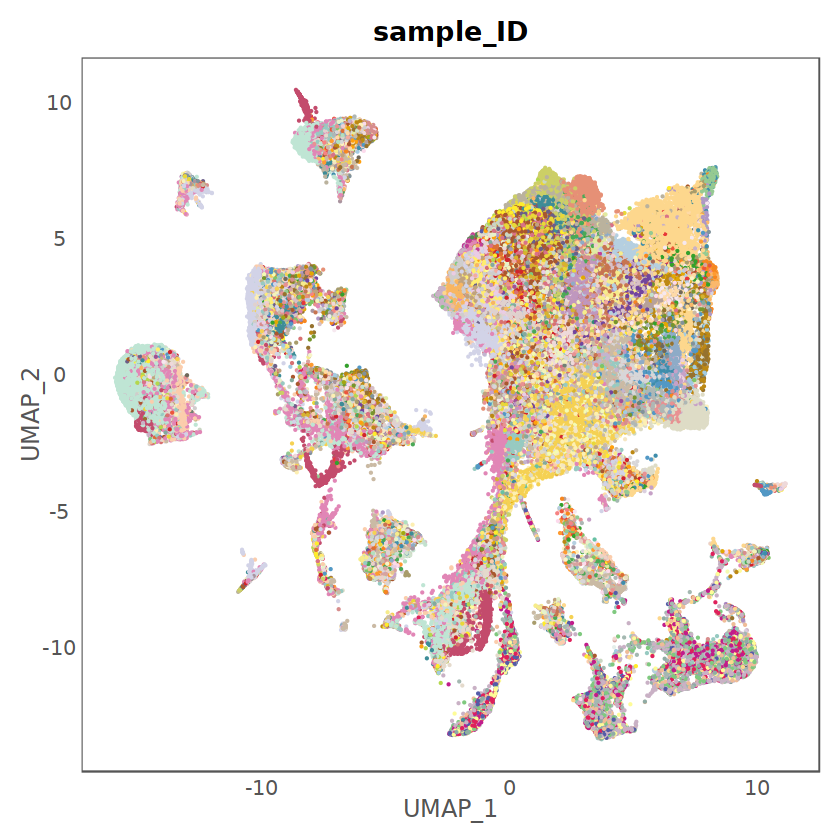

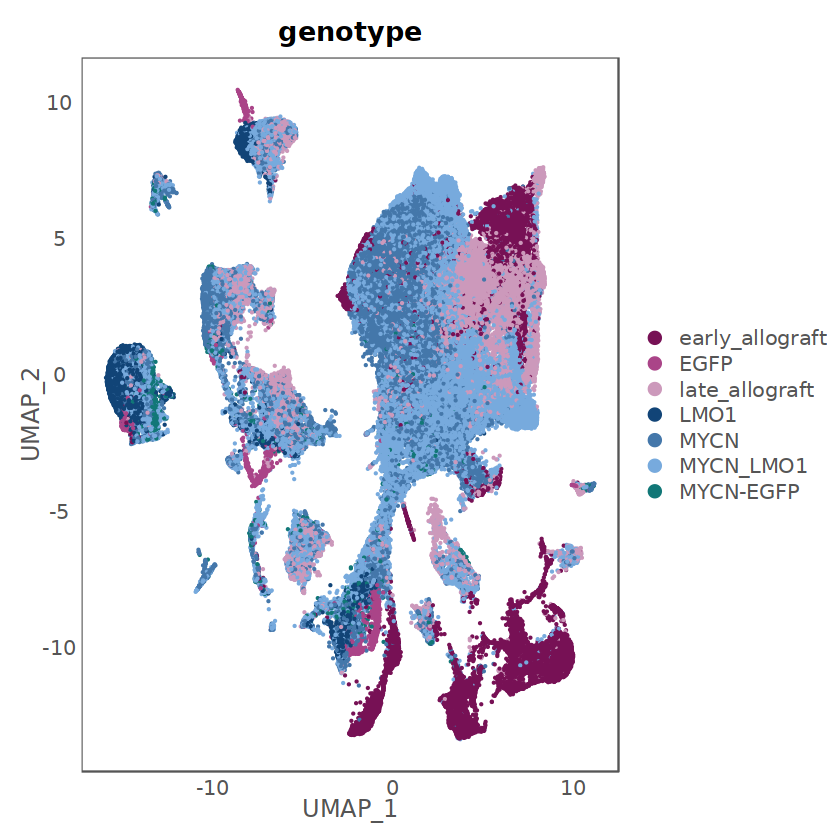

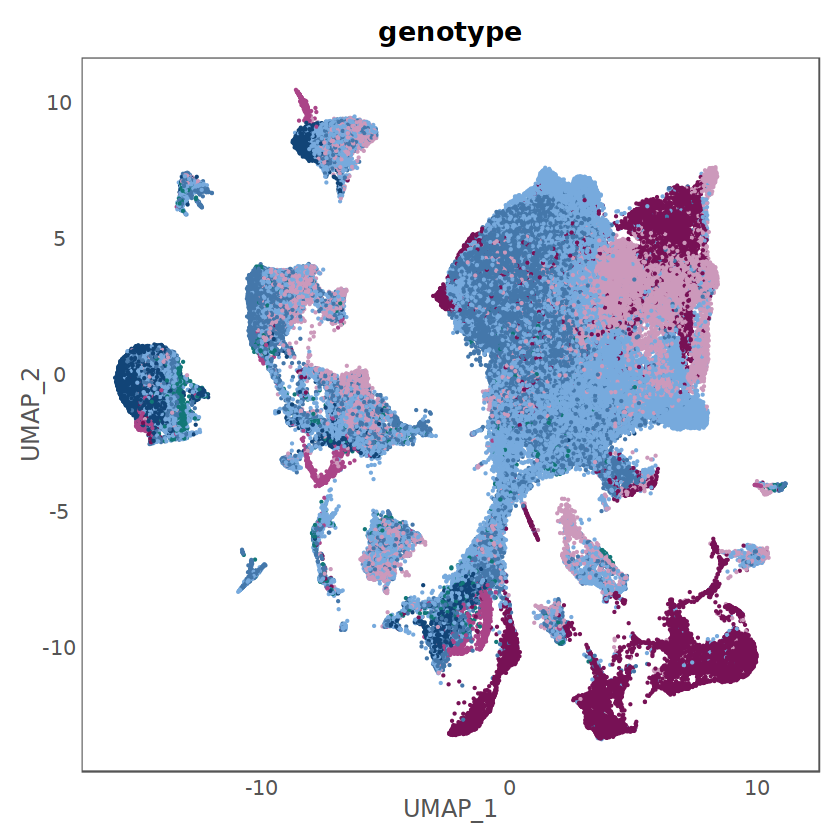

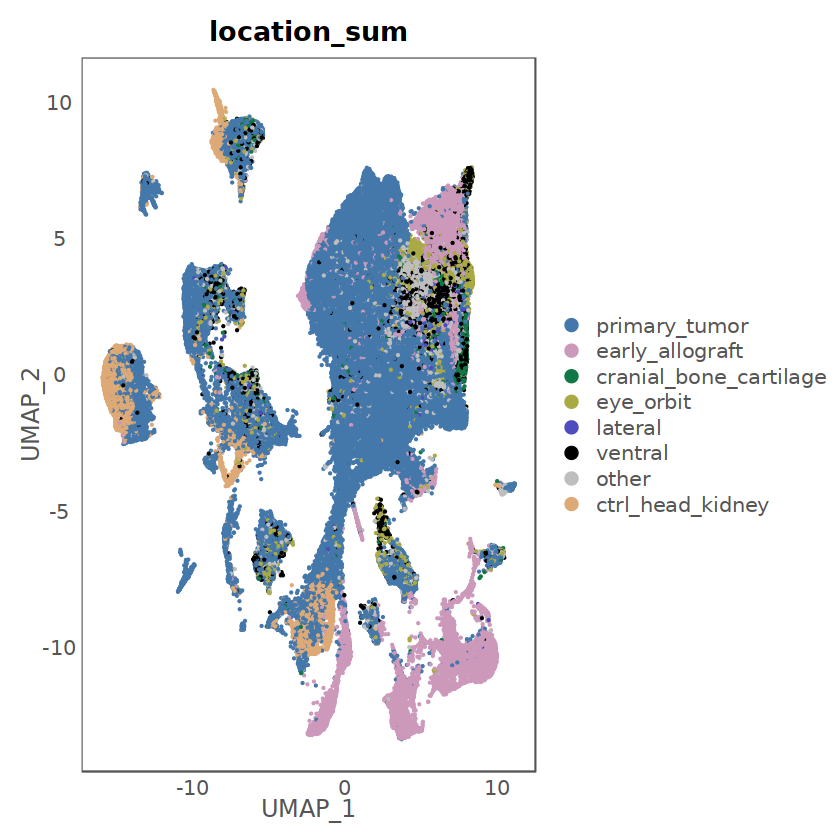

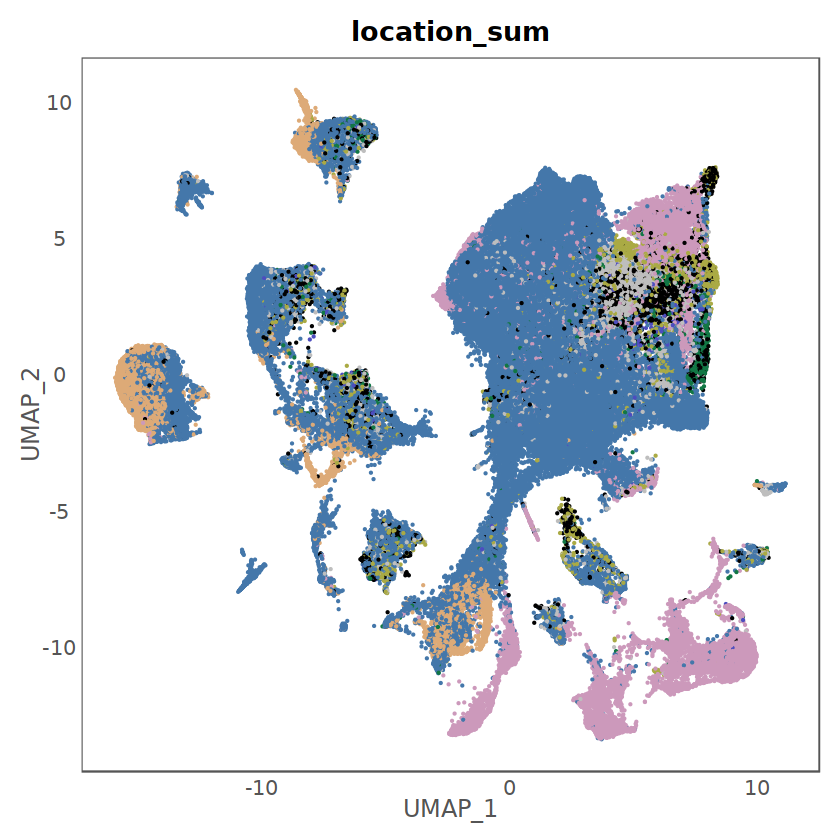

In [38]:
# Plots
set.seed(478)
n <- length(unique(dat@meta.data$sample_ID))
qual_col_pals <- brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector_det <- unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))
col_vector_det <- colorRampPalette(col_vector_det)(n)

DimPlot(object = dat, reduction = 'umap', pt.size = 0.15, group.by = "sample_ID", cols = col_vector_det, shuffle = T, raster=FALSE) +
                     NoAxes() +
                     NoLegend() +
                     mytheme_angledYtitle


DimPlot(object = dat, reduction = 'umap', pt.size = 0.15, group.by = "genotype", cols = tol21rainbow, shuffle = T, raster=FALSE) +
                     NoAxes() +
                     mytheme_angledYtitle

DimPlot(object = dat, reduction = 'umap', pt.size = 0.15, group.by = "genotype", cols = tol21rainbow, shuffle = T, raster=FALSE) +
                     NoAxes() +
                     NoLegend() +
                     mytheme_angledYtitle


DimPlot(dat, group.by = 'location_sum', pt.size = 0.15, cols = c(tol21rainbow[c(5,3,10,14,31)],'black','grey',tol21rainbow[18]), shuffle = T, raster=FALSE)+
                     NoAxes() +
                     mytheme_angledYtitle

DimPlot(dat, group.by = 'location_sum', pt.size = 0.15, cols = c(tol21rainbow[c(5,3,10,14,31)],'black','grey',tol21rainbow[18]), shuffle = T, raster=FALSE)+
                     NoAxes() +
                     NoLegend() +
                     mytheme_angledYtitle

In [39]:
# Save
save(dat, file = paste0("./data_allTPs/",dat_name,"_clustered.Robj"))